# Notebook Dedicado a construir modelo Optimizados en cada regimen de energia usando Optuna

Regimes de prueba:

- [2,4] MeV (Hecho) - Optimizado -> Si, pesimos resultados. trial = 300
- [4,6] MeV (hecho) - Optimizado ?
- [2,10] MeV (hecho) - Optimizado -> Si, (esperando resultados). trial = 50
- [2,6] MeV - optimizado (hecho)
- [0.5, 16] MeV- Optimizado (trial = 100)

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# 1 - Load Data

In [78]:
image_dim = (10, 10)
df_train = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/train/df_reduced_5500_10_(2.5_14)_(-5_7).csv"))
df_test = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/test/df_test_5500_10_(2.5_14)_(-5_7).csv"))

In [4]:
df_train.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,...,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000,168091.000000
mean,48101.820329,0.106513,0.090626,0.099528,0.103548,0.103828,0.103830,0.104008,0.104136,0.104236,...,0.098086,0.098368,0.098475,0.099130,0.099680,0.100807,5.568478,4082.295650,0.690180,0.309820
std,32598.203125,0.258851,0.216833,0.196060,0.174377,0.154222,0.138390,0.125238,0.113282,0.102508,...,0.148719,0.133906,0.121533,0.110540,0.100627,0.092076,2.311816,1075.312387,0.462421,0.462421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500081,66.302811,0.000000,0.000000
25%,21011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023810,0.030303,...,0.000000,0.000000,0.000000,0.021277,0.028169,0.034483,3.657920,3403.060547,0.000000,0.000000
50%,42022.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.048780,0.057143,0.064815,0.071429,...,0.031250,0.045455,0.052632,0.058824,0.066667,0.073171,4.641886,4315.275391,1.000000,0.000000
75%,73989.500000,0.000000,0.000000,0.125000,0.142857,0.150000,0.152174,0.151515,0.150000,0.148649,...,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,7.421789,4963.363525,1.000000,1.000000
max,116012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.896552,0.816327,0.828571,...,1.000000,1.000000,0.869565,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


In [94]:
df_test.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,...,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000,69440.000000
mean,17359.500000,0.101851,0.088344,0.097730,0.101526,0.101727,0.102524,0.102622,0.102860,0.103883,...,0.100303,0.101453,0.101331,0.102479,0.103141,0.104153,4.422798,4106.450430,0.500000,0.500000
std,10022.872839,0.253715,0.217223,0.196499,0.175413,0.155141,0.140647,0.127167,0.115781,0.106405,...,0.150548,0.136830,0.123813,0.113874,0.104076,0.095627,1.584180,1069.562697,0.500004,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500030,106.154373,0.000000,0.000000
25%,8679.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.028571,...,0.000000,0.000000,0.000000,0.022727,0.029412,0.034483,3.444127,3433.930725,0.000000,0.000000
50%,17359.500000,0.000000,0.000000,0.000000,0.000000,0.025641,0.047619,0.055556,0.062500,0.068966,...,0.032258,0.048780,0.055556,0.062500,0.069767,0.075000,3.877555,4347.353271,0.500000,0.500000
75%,26039.250000,0.000000,0.000000,0.111111,0.142857,0.142857,0.150000,0.150000,0.148148,0.148148,...,0.142857,0.148148,0.146341,0.148148,0.147953,0.147059,4.789484,4983.035156,1.000000,1.000000
max,34719.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000,0.814815,0.766667,...,1.000000,0.909091,0.909091,0.774194,0.821429,0.708333,13.663218,5499.971680,1.000000,1.000000


# 2 - Data Preprocesing

## 2.1 - Extract Information

In [143]:
pixel_pattern = r'^pixel_\d+$'
energy_cut_train = 12
energy_cut_test = 8

### Extracting training Data

In [144]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])
    
#Separate Features for signal and background
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

In [138]:
df_pixel_sig_train.shape

(52078, 100)

### Extracting test Data

In [145]:
equal_evs = False #Igualar eventos de 208-Tl y Solar Nu

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1]).drop(columns=['Unnamed: 0'])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])

#Separate Features for signal and background
df_pixel_sig_test = dataset_sig_test.filter(regex=pixel_pattern)
df_energy_sig_test = (dataset_sig_test[['energy (MeV)']])
df_radi_sig_test = (dataset_sig_test[['radius (mm)']])
df_label_sig_test = pd.DataFrame(dataset_sig_test, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_test = dataset_bkg_test.filter(regex=pixel_pattern)
df_energy_bkg_test= (dataset_bkg_test[['energy (MeV)']])
df_radi_bkg_test = (dataset_bkg_test[['radius (mm)']])
df_label_bkg_test = pd.DataFrame(dataset_bkg_test, columns = ['IsNu', 'IsTl'])

In [140]:
np.max(df_energy_sig_test)

11.983275413513184

In [147]:
df_pixel_bkg_test.shape

(34720, 100)

#### Observe plots of DataSet

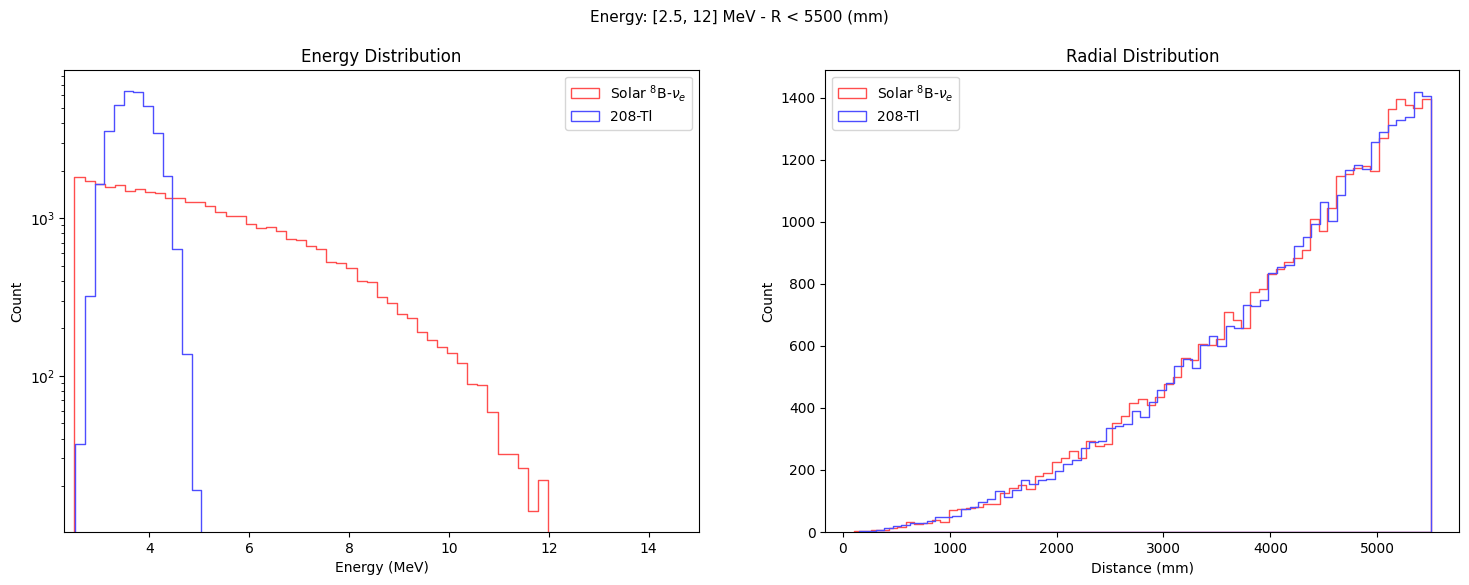

In [76]:
#default (testing data) Energy_Solar_and_Tl_distribution

binwidth_en = 0.2
binwidth_rad = 80
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Distribution
sn.histplot(df_energy_sig_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[0], element="step", label = 'Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = '208-Tl')

#Radial Distribution
sn.histplot(df_radi_sig_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0], element="step", label = 'Solar $^8$B-$ν_e$')
sn.histplot(df_radi_bkg_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = '208-Tl')


axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title('Radial Distribution', fontsize = 12)
plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Distance (mm)')
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(2.3, 15)

plt.savefig('figs/default_Energy_and_Radius_Distribution.png', format = 'png', bbox_inches = 'tight')
plt.show()

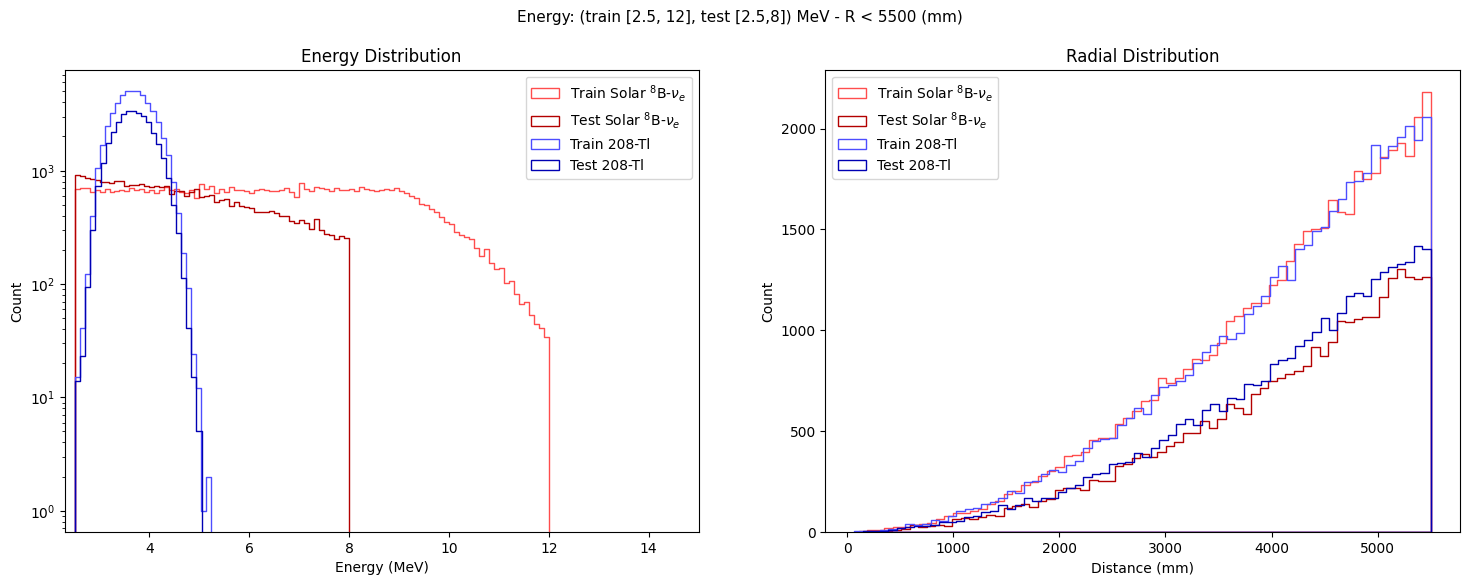

In [12]:
binwidth_en = 0.1
binwidth_rad = 80
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Distribution
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_energy_sig_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_energy_bkg_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

#Radial Distribution
sn.histplot(df_radi_sig_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_radi_sig_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_radi_bkg_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_radi_bkg_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')


axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title('Radial Distribution', fontsize = 12)
plt.suptitle('Energy: (train [2.5, 12], test [2.5,8]) MeV - R < 5500 (mm)', fontsize = 11)

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Distance (mm)')
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(2.3, 15)

#plt.savefig('figs/Optimized Models/10x10/Energy_and_Radius_Distribution.png', format = 'png', bbox_inches = 'tight')
plt.show()

## 2.2 - Data Split (Train, Test and Validation)

In [13]:
pixel_sig_train = df_pixel_sig_train
label_sig_train = df_label_sig_train
energy_sig_train = df_energy_sig_train
radi_sig_train = df_radi_sig_train

pixel_bkg_train = df_pixel_bkg_train
label_bkg_train = df_label_bkg_train
energy_bkg_train = df_energy_bkg_train
radi_bkg_train = df_radi_bkg_train

## 2.4 - Data Transformation

### 2.4.1 - Standard Scaler

In [14]:
# A Standard Scalar is used as transform, with a mean_value = 0 and std_deviation = 1

#This scaler is used in data we dont intend to recover in org. scale
scaler = StandardScaler()  

#Scalers applied to (energy, radius) of testing data, since we want to recover its org. representation
scaler_en_sig = StandardScaler()
scaler_en_bkg = StandardScaler()

scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

#std(Train):
pixel_sig_train_transf = scaler.fit_transform(pixel_sig_train)
pixel_bkg_train_transf = scaler.fit_transform(pixel_bkg_train)

energy_sig_train_transf = scaler.fit_transform(energy_sig_train).T[0]
energy_bkg_train_transf = scaler.fit_transform(energy_bkg_train).T[0]

radi_sig_train_transf = scaler.fit_transform(radi_sig_train).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train).T[0]

#std(Validation):
#pixel_sig_val_transf = scaler.fit_transform(pixel_sig_val)
#pixel_bkg_val_transf = scaler.fit_transform(pixel_bkg_val)

#energy_sig_val_transf = scaler.fit_transform(energy_sig_val).T[0]
#energy_bkg_val_transf = scaler.fit_transform(energy_bkg_val).T[0]

#radi_sig_val_transf = scaler.fit_transform(radi_sig_val).T[0]
#radi_bkg_val_transf = scaler.fit_transform(radi_bkg_val).T[0]

#std(test):
pixel_sig_test_transf = scaler.fit_transform(df_pixel_sig_test)
pixel_bkg_test_transf = scaler.fit_transform(df_pixel_bkg_test)

energy_sig_test_transf = scaler_en_sig.fit_transform(df_energy_sig_test).T[0]
energy_bkg_test_transf = scaler_en_bkg.fit_transform(df_energy_bkg_test).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(df_radi_sig_test).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(df_radi_bkg_test).T[0]

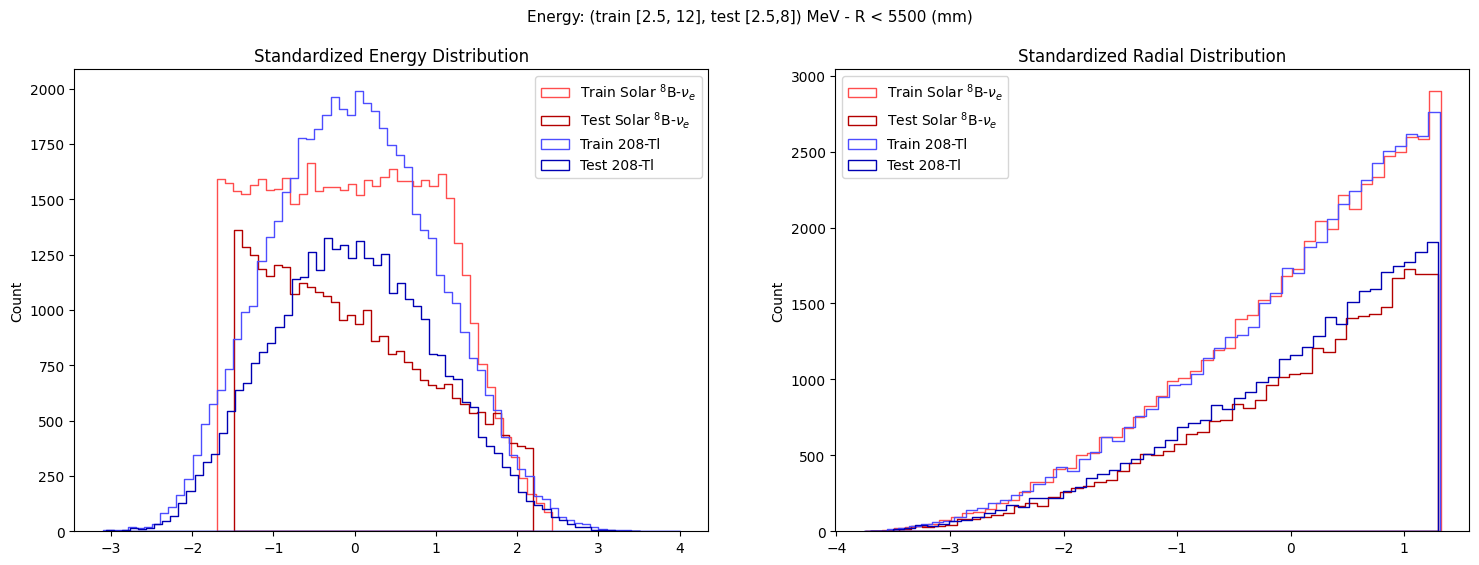

In [15]:
#Plots of Standardized Energy and Radius

binwidth = 0.1
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(energy_sig_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(energy_sig_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(energy_bkg_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

#StandScaler Radius
sn.histplot(radi_sig_train_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(radi_sig_test_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(radi_bkg_train_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(radi_bkg_test_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

axes[0].set_title('Standardized Energy Distribution', fontsize = 12)
axes[1].set_title('Standardized Radial Distribution', fontsize = 12)
plt.suptitle('Energy: (train [2.5, 12], test [2.5,8]) MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

#axes[0].set_yscale('log')

#axes[0].set_xlim(2.3, 15)

#plt.savefig('figs/Optimized Models/10x10/StandardizedEnergy_and_Radius.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 2.4.2 - Volume Normalization (radius)

In [115]:
vol = 5500**3

radi_sig_train_transf = (radi_sig_train**3)/vol
radi_bkg_train_transf = (radi_bkg_train**3)/vol

#radi_sig_val_transf = (radi_sig_val**3)/vol
#radi_bkg_val_transf = (radi_bkg_val**3)/vol

radi_sig_test_transf = (df_radi_sig_test**3)/vol
radi_bkg_test_transf = (df_radi_bkg_test**3)/vol

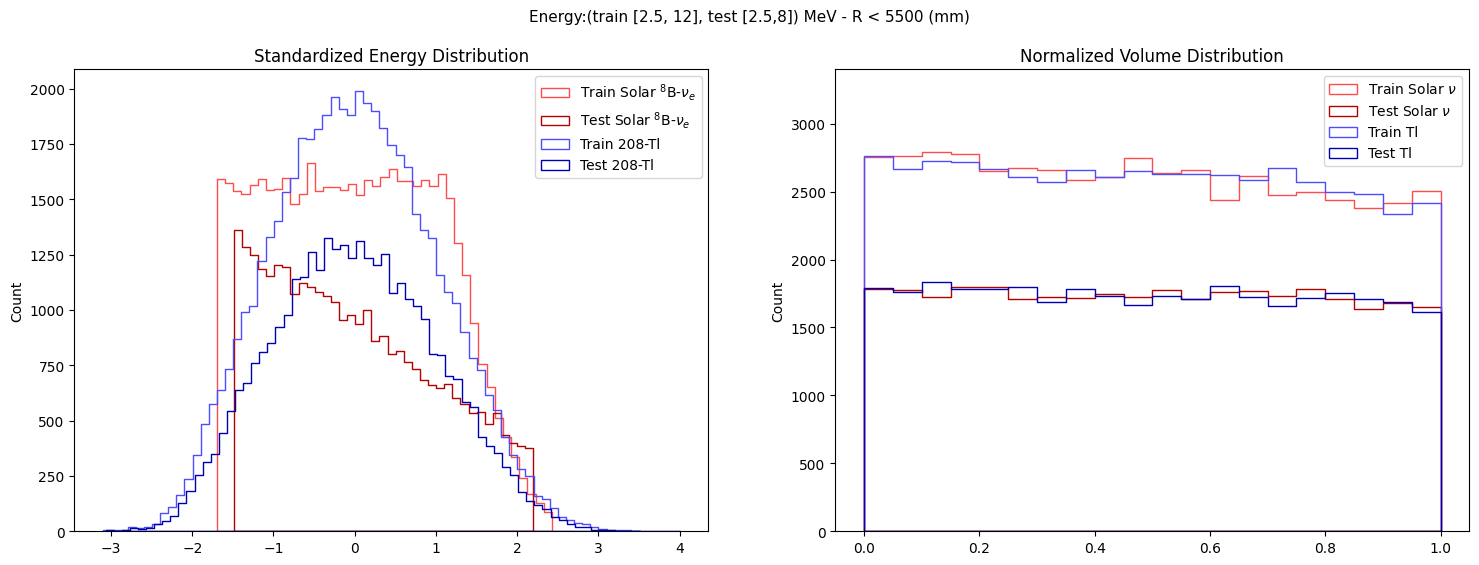

In [116]:
#Plots of Standardized Energy and Volume Norm

binwidth_en = 0.1
binwidth_rad = 0.05
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

# energy
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[0], element="step", label = 'Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = '208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test Tl')

axes[0].set_title('Standardized Energy Distribution', fontsize = 12)
axes[1].set_title('Normalized Volume Distribution', fontsize = 12)

plt.suptitle('Energy:(train [2.5, 12], test [2.5,8]) MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

#axes[0].set_yscale('log')
axes[1].set_ylim(0, 3400)

#plt.savefig('figs/Optimized Models/10x10/StandardizedEnergy_and_Vol_Norm.png', format = 'png', bbox_inches = 'tight')
plt.show()

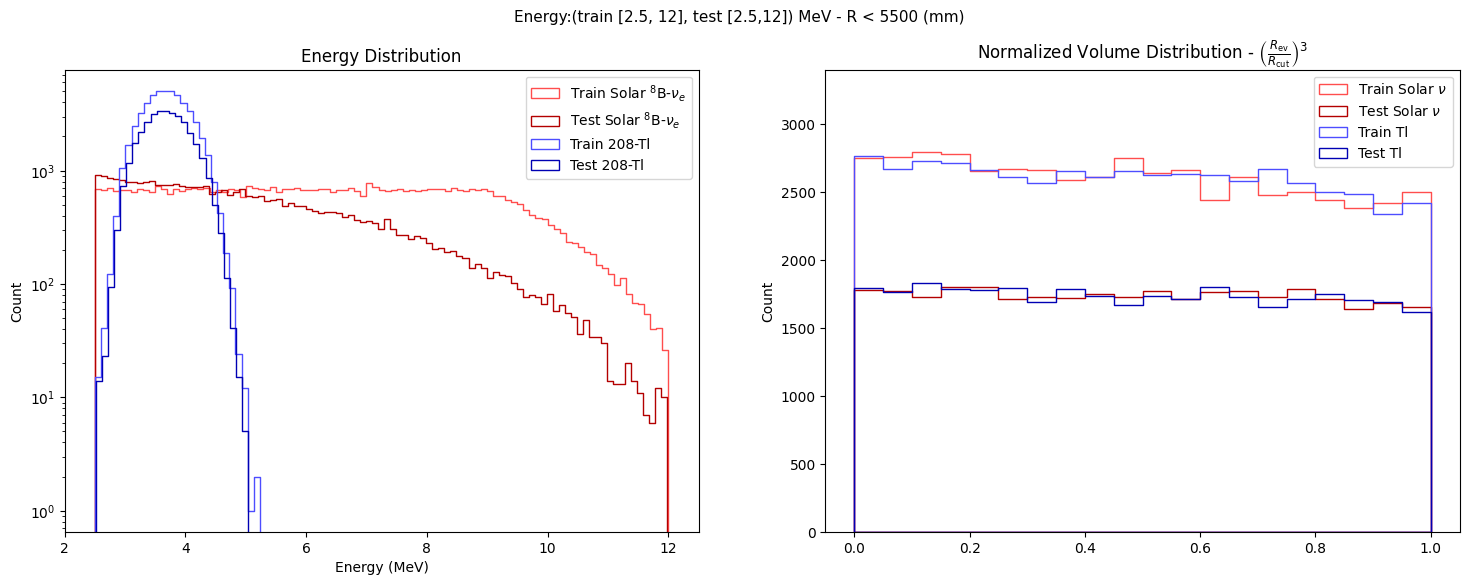

In [135]:
#Plots of flat Energy and Volume Norm

binwidth_en = 0.1
binwidth_rad = 0.05
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_energy_sig_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_energy_bkg_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test Tl')

axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title(r'Normalized Volume Distribution - $\left(\frac{R_{\text{ev}}}{R_{\text{cut}}}\right)^3$', fontsize = 12)

axes[0].set_xlabel('Energy (MeV)')
#axes[1].set_xlabel('Distance (mm)')

plt.suptitle('Energy:(train [2.5, 12], test [2.5,12]) MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

axes[0].set_yscale('log')
axes[0].set_xlim(2, 12.5)
axes[1].set_ylim(0, 3400)

plt.savefig('figs/Energy_and_Vol_Norm_Distribution_5500_train_(2.5_12)_test_(2.5_12).png', format = 'png', bbox_inches = 'tight')
plt.show()

### 2.4.3 - Standard Scaler of Volume Normalization

CUIDADO QUE SE HAN REDEFINIDO VARIABLE CON SU PROPIO NOMBRE!

In [ ]:
scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

radi_sig_train_transf = scaler.fit_transform(radi_sig_train_transf).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train_transf).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(radi_sig_test_transf).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(radi_bkg_test_transf).T[0]

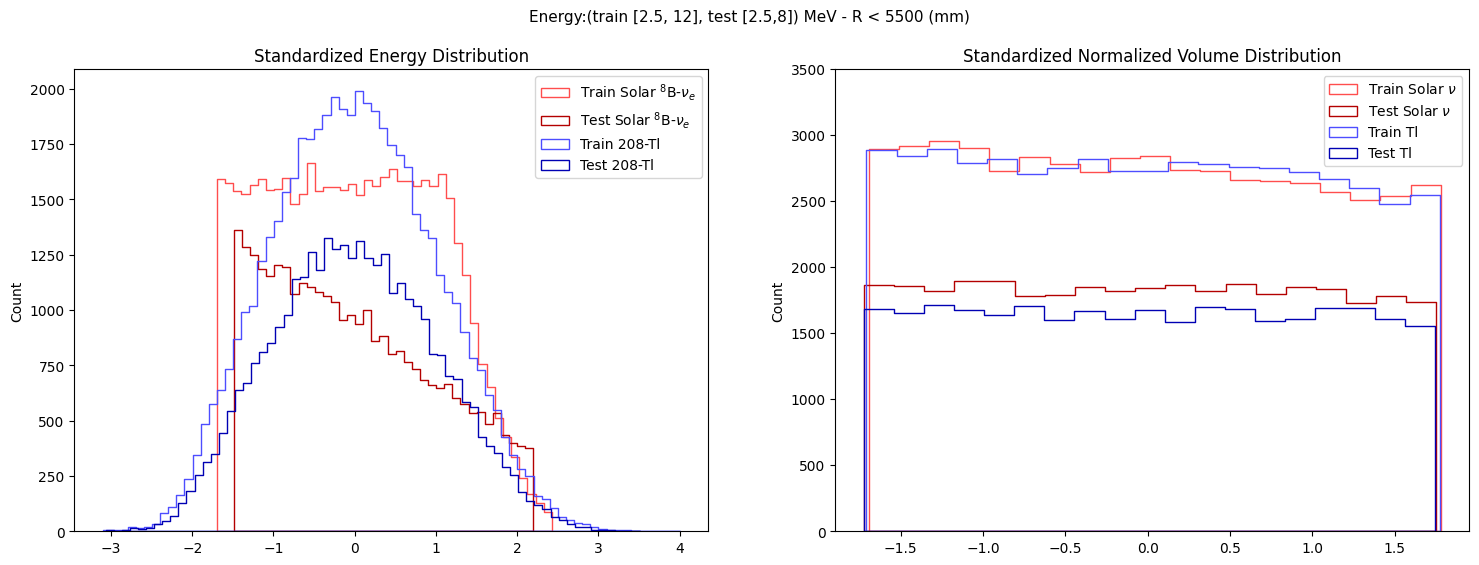

In [113]:
#Plots of Standardized Energy and Volume Norm

binwidth_en = 0.1
binwidth_rad = 0.18
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(energy_sig_train_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(energy_sig_test_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_train_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(energy_bkg_test_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf, binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf, binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf, binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf, binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test Tl')

axes[0].set_title('Standardized Energy Distribution', fontsize = 12)
axes[1].set_title('Standardized Normalized Volume Distribution', fontsize = 12)
plt.suptitle('Energy:(train [2.5, 12], test [2.5,8]) MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

#axes[0].set_yscale('log')
axes[1].set_ylim(0, 3500)

#plt.savefig('figs/Optimized Models/10x10/StandardizedEnergy_and_Std_Vol_Norm.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [43]:
energy_sig_test_transf

array([-0.02660311, -1.17541425, -1.12456211, ...,  1.23191677,
        2.28366455, -1.01703393])

## 2.5 - Unify DataSets

In [28]:
#Unify datasets

pixel_train = np.concatenate((pixel_sig_train_transf, pixel_bkg_train_transf))
energy_train = np.concatenate((energy_sig_train_transf, energy_bkg_train_transf))
radi_train = np.concatenate((radi_sig_train_transf, radi_bkg_train_transf))#.T[0]
label_train = np.concatenate((label_sig_train, label_bkg_train))

#pixel_val = np.concatenate((pixel_sig_val_transf, pixel_bkg_val_transf))
#energy_val = np.concatenate((energy_sig_val_transf, energy_bkg_val_transf))
#radi_val = np.concatenate((radi_sig_val_transf, radi_bkg_val_transf)).T[0]
#label_val = np.concatenate((label_sig_val, label_bkg_val))

pixel_test = np.concatenate ((pixel_sig_test_transf, pixel_bkg_test_transf))
energy_test = np.concatenate((energy_sig_test_transf, energy_bkg_test_transf))
radi_test = np.concatenate((radi_sig_test_transf, radi_bkg_test_transf))#.T[0]
label_test = np.concatenate((df_label_sig_test, df_label_bkg_test))

In [29]:
radi_train

array([-1.46869658,  0.87039695, -0.51950667, ..., -1.19104313,
       -0.96767006, -0.8431589 ])

# 3 - Model Optimization

Hyperparams. to optimize:
- Learning Rate
- Number of neurons
- Number of Hidden layers:
   1) Hidden layers of Image
   4) Hidden layers before dropout layer
   5) Hidden layers after dropout layers
- Dropout Rate

In [34]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    #Optimization of Hyperparameters

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 10)

    #Energy layers suggestions
    n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    # Nº of neurons suggestion
    #Before Dropout Layers - before concatenate
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 3)

    #After Dropout Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 3)

    #Learning Rate and Dropout rate
    lr_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #Number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    n_units_en_ly = []
    n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Arquitectura--------------------------------------------------------------------------
    #Input Layers
    #image
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Radius
    input_rad = Input(shape = (1,), name = 'radius_input')

    #Hidden Layers for Image (decreasing number of neurons)
    #first Image Hidden Layer
    n_neurons = trial.suggest_int('n_neurons_im_ly_0', 70, 90)
    image_ly = Dense(n_neurons, activation = 'gelu', name = 'im_ly_0')(input_image)
    for i in range(n_image_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, 70)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de 50!
        n_units_image_ly.append(n_neurons)
            
        image_ly = Dense(n_neurons, activation = 'gelu', name = f'im_ly_{i+1}')(image_ly)

    #Hidden Layers for Energy
    #first energy Hidden Layer
    n_en_neurons = trial.suggest_int('n_neurons_en_ly_0', 50, 70)
    energy_ly = Dense(n_en_neurons, activation = 'gelu', name = 'en_ly_0')(input_energy)
    for i in range(n_en_layers):
        if i == 0:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, 50)
        else:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, n_units_en_ly[i-1])
        n_units_en_ly.append(n_en_neurons)

        energy_ly = Dense(n_en_neurons, activation = 'gelu', name = f'en_ly_{i+1}')(energy_ly)

    #Hidden Layers for Radius
    #first radial hidden layer
    n_rad_neurons = trial.suggest_int('n_neurons_rad_ly_0', 50, 70)
    radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = 'rad_ly_0')(input_rad)
    for i in range(n_rad_layers):
        if i == 0:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, 50)
        else:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, n_units_rad_ly[i-1])
        n_units_rad_ly.append(n_rad_neurons)

        radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = f'rad_ly_{i+1}')(radial_ly)

    #Concatenate info:
    x = concatenate([image_ly, input_energy, input_rad])

    #first hidden layer after concatenate: Maximum neurons = min(en_units) + min(rad_units) + min(im_units) of last layer
    n_neurons = trial.suggest_int('n_neurons_bdo_ly_0', 30, n_rad_neurons + n_en_neurons + n_neurons)
    x = Dense(n_neurons, activation = 'gelu', name = 'bdo_ly_0')(x)
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_units_bdo_ly[i-1])
        n_units_bdo_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i+1}')(x)

    #Dropout Layer
    x = Dropout(rate = do_rate)(x)

    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)
        
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

    model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train}, 
                    epochs = 150, 
                    batch_size = 100,
                    validation_split = 0.3,
                    #validation_data = ({'image_input': pixel_val.to_numpy(), 'energy_input': energy_val, 'radius_input': radi_val}, label_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-2)],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_sig_test_transf, energy_sig_test_transf, radi_sig_test_transf])
    X_bkg_pred = model.predict([pixel_bkg_test_transf, energy_bkg_test_transf, radi_bkg_test_transf])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))         #Predicted
    x_exp = np.concatenate((df_label_sig_test, df_label_bkg_test))  #expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [35]:
study = optuna.create_study(directions = ["maximize"])
study.optimize(objective, n_trials = 80)
best_trial = study.best_trial

print("Best Hyperparms.:", study.best_trial.params) #To see the best 
print("Value: ", best_trial.value)

[I 2024-08-02 00:40:31,590] A new study created in memory with name: no-name-f5af4a54-3ca0-4944-824a-4a210bb6f7c2


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7400 - accuracy: 0.7102 - loss: 0.5944 - val_AUC: 0.3233 - val_accuracy: 0.3285 - val_loss: 0.9816
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8806 - accuracy: 0.7961 - loss: 0.4278 - val_AUC: 0.7821 - val_accuracy: 0.6632 - val_loss: 0.6591
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9658 - accuracy: 0.8972 - loss: 0.2356 - val_AUC: 0.9292 - val_accuracy: 0.8114 - val_loss: 0.3281
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9811 - accuracy: 0.9242 - loss: 0.1751 - val_AUC: 0.9729 - val_accuracy: 0.8683 - val_loss: 0.1970
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9850 - accuracy: 0.9341 - loss: 0.1562 - val_AUC: 0.9510 - val_accuracy: 0.8416 - val_loss: 0.2745
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9904 - accuracy: 0.9485 - loss: 0.1239 - val_AUC: 0.9475 - val_accuracy: 0.8345 - val_loss: 0.2830
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:42:11,440] Trial 0 finished with value: 0.9623247087395705 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.005804860746914509, 'Drop_out_rate': 0.22828869601697416, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 73, 'n_neurons_bdo_ly_1': 38, 'n_neurons_bdo_ly_2': 38, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 19}. Best is trial 0 with value: 0.9623247087395705.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7110 - accuracy: 0.7105 - loss: 0.6130 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2433
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7141 - accuracy: 0.7129 - loss: 0.6003 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2529
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7164 - accuracy: 0.7142 - loss: 0.5985 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2669
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7149 - accuracy: 0.7153 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2182
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7143 - accuracy: 0.7140 - loss: 0.5986 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2698
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7170 - accuracy: 0.7160 - loss: 0.5967 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 00:43:47,778] Trial 1 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.00933847462898479, 'Drop_out_rate': 0.670205876504522, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 49, 'n_neurons_en_ly_2': 48, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 44, 'n_neurons_rad_ly_3': 36, 'n_neurons_bdo_ly_0': 36, 'n_neurons_bdo_ly_1': 36, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 20, 'n_neurons_ado_ly_2': 17}. Best is trial 0 with value: 0.9623247087395705.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7326 - accuracy: 0.7130 - loss: 0.5997 - val_AUC: 0.1344 - val_accuracy: 0.2606 - val_loss: 1.0713
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8428 - accuracy: 0.7663 - loss: 0.4878 - val_AUC: 0.8093 - val_accuracy: 0.7026 - val_loss: 0.5871
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9550 - accuracy: 0.8805 - loss: 0.2689 - val_AUC: 0.9283 - val_accuracy: 0.8182 - val_loss: 0.3234
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9786 - accuracy: 0.9192 - loss: 0.1872 - val_AUC: 0.9175 - val_accuracy: 0.8155 - val_loss: 0.3996
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9830 - accuracy: 0.9303 - loss: 0.1656 - val_AUC: 0.9517 - val_accuracy: 0.8359 - val_loss: 0.2986
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9849 - accuracy: 0.9351 - loss: 0.1555 - val_AUC: 0.9266 - val_accuracy: 0.8273 - val_loss: 0.3745
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:47:46,682] Trial 2 finished with value: 0.9855368958171502 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0032337211736645512, 'Drop_out_rate': 0.5337124139679758, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 54, 'n_neurons_bdo_ly_1': 33, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 24}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7120 - accuracy: 0.7112 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2453
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7149 - accuracy: 0.7154 - loss: 0.5974 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2287
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7149 - accuracy: 0.7149 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2258
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7148 - accuracy: 0.7163 - loss: 0.5968 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1970
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7117 - accuracy: 0.7126 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2995
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7111 - accuracy: 0.7129 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 00:50:21,746] Trial 3 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.00819985222787738, 'Drop_out_rate': 0.6668163634995904, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 50, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 35, 'n_neurons_bdo_ly_0': 129, 'n_neurons_bdo_ly_1': 112, 'n_neurons_bdo_ly_2': 111, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 10}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.7146 - accuracy: 0.7089 - loss: 0.6066 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2229
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7390 - accuracy: 0.7153 - loss: 0.5930 - val_AUC: 0.0225 - val_accuracy: 0.0157 - val_loss: 1.3149
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7776 - accuracy: 0.7218 - loss: 0.5651 - val_AUC: 0.5896 - val_accuracy: 0.5478 - val_loss: 0.8411
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9149 - accuracy: 0.8314 - loss: 0.3667 - val_AUC: 0.8869 - val_accuracy: 0.7703 - val_loss: 0.4378
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9655 - accuracy: 0.8988 - loss: 0.2366 - val_AUC: 0.8275 - val_accuracy: 0.6876 - val_loss: 0.5960
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9815 - accuracy: 0.9258 - loss: 0.1731 - val_AUC: 0.9579 - val_accuracy: 0.8528 - val_loss: 0.2837
Epoch 7/150
730/730 ━━━━━━

[I 2024-08-02 00:52:29,602] Trial 4 finished with value: 0.940313771361554 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.003285240233540884, 'Drop_out_rate': 0.2452592606781635, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 30, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 39, 'n_neurons_rad_ly_2': 33, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 97, 'n_neurons_bdo_ly_1': 92, 'n_neurons_ado_ly_0': 80, 'n_neurons_ado_ly_1': 14}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7613 - accuracy: 0.7235 - loss: 0.5786 - val_AUC: 0.5692 - val_accuracy: 0.5036 - val_loss: 0.7480
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9228 - accuracy: 0.8440 - loss: 0.3491 - val_AUC: 0.8920 - val_accuracy: 0.7681 - val_loss: 0.4016
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9753 - accuracy: 0.9131 - loss: 0.2002 - val_AUC: 0.9531 - val_accuracy: 0.8543 - val_loss: 0.2943
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9847 - accuracy: 0.9350 - loss: 0.1567 - val_AUC: 0.9293 - val_accuracy: 0.8239 - val_loss: 0.3526
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9904 - accuracy: 0.9497 - loss: 0.1243 - val_AUC: 0.9358 - val_accuracy: 0.8212 - val_loss: 0.3603
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9919 - accuracy: 0.9536 - loss: 0.1136 - val_AUC: 0.9704 - val_accuracy: 0.8794 - val_loss: 0.2207
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:53:58,412] Trial 5 finished with value: 0.9827819456715963 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.002523285328121609, 'Drop_out_rate': 0.49501702195464437, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 47, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 32, 'n_neurons_rad_ly_2': 31, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 116, 'n_neurons_bdo_ly_1': 35, 'n_neurons_bdo_ly_2': 32, 'n_neurons_ado_ly_0': 19}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7566 - accuracy: 0.7168 - loss: 0.5838 - val_AUC: 0.3759 - val_accuracy: 0.3647 - val_loss: 0.9340
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8956 - accuracy: 0.8114 - loss: 0.4041 - val_AUC: 0.7880 - val_accuracy: 0.6803 - val_loss: 0.6002
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9650 - accuracy: 0.8948 - loss: 0.2387 - val_AUC: 0.8797 - val_accuracy: 0.7591 - val_loss: 0.4522
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9788 - accuracy: 0.9196 - loss: 0.1853 - val_AUC: 0.9130 - val_accuracy: 0.8030 - val_loss: 0.3901
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9851 - accuracy: 0.9343 - loss: 0.1555 - val_AUC: 0.9375 - val_accuracy: 0.8360 - val_loss: 0.3410
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9892 - accuracy: 0.9441 - loss: 0.1320 - val_AUC: 0.9388 - val_accuracy: 0.8342 - val_loss: 0.3431
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:55:22,495] Trial 6 finished with value: 0.9746829868501165 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0012675920309935121, 'Drop_out_rate': 0.14855359089139375, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 52, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 33, 'n_neurons_rad_ly_2': 31, 'n_neurons_bdo_ly_0': 51, 'n_neurons_bdo_ly_1': 40, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 14}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7611 - accuracy: 0.7188 - loss: 0.5788 - val_AUC: 0.6114 - val_accuracy: 0.5420 - val_loss: 0.7324
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9138 - accuracy: 0.8318 - loss: 0.3656 - val_AUC: 0.8832 - val_accuracy: 0.7561 - val_loss: 0.4232
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9649 - accuracy: 0.8953 - loss: 0.2371 - val_AUC: 0.9307 - val_accuracy: 0.8164 - val_loss: 0.3470
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9771 - accuracy: 0.9172 - loss: 0.1928 - val_AUC: 0.9538 - val_accuracy: 0.8564 - val_loss: 0.2705
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9858 - accuracy: 0.9360 - loss: 0.1514 - val_AUC: 0.9168 - val_accuracy: 0.8061 - val_loss: 0.3903
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9883 - accuracy: 0.9415 - loss: 0.1371 - val_AUC: 0.9642 - val_accuracy: 0.8580 - val_loss: 0.2341
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:57:31,040] Trial 7 finished with value: 0.46680483169813247 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.005743833134933177, 'Drop_out_rate': 0.08488950078042774, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 54, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 44, 'n_neurons_rad_ly_0': 69, 'n_neurons_rad_ly_1': 42, 'n_neurons_rad_ly_2': 37, 'n_neurons_bdo_ly_0': 108, 'n_neurons_bdo_ly_1': 33, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7753 - accuracy: 0.7275 - loss: 0.5658 - val_AUC: 0.6708 - val_accuracy: 0.5588 - val_loss: 0.6740
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9332 - accuracy: 0.8523 - loss: 0.3244 - val_AUC: 0.8638 - val_accuracy: 0.7221 - val_loss: 0.5114
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9752 - accuracy: 0.9129 - loss: 0.2000 - val_AUC: 0.8377 - val_accuracy: 0.6872 - val_loss: 0.6785
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9843 - accuracy: 0.9304 - loss: 0.1594 - val_AUC: 0.9641 - val_accuracy: 0.8679 - val_loss: 0.2541
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9896 - accuracy: 0.9445 - loss: 0.1298 - val_AUC: 0.9387 - val_accuracy: 0.8335 - val_loss: 0.3336
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9919 - accuracy: 0.9514 - loss: 0.1139 - val_AUC: 0.9307 - val_accuracy: 0.8364 - val_loss: 0.4067
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 00:59:04,804] Trial 8 finished with value: 0.9792010733585758 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.003033023824657044, 'Drop_out_rate': 0.355828931548803, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 68, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 43, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 90, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 11}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7549 - accuracy: 0.7166 - loss: 0.5841 - val_AUC: 0.1406 - val_accuracy: 0.2071 - val_loss: 1.2482
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8964 - accuracy: 0.8141 - loss: 0.4018 - val_AUC: 0.9017 - val_accuracy: 0.7602 - val_loss: 0.3979
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9654 - accuracy: 0.8957 - loss: 0.2359 - val_AUC: 0.9111 - val_accuracy: 0.8050 - val_loss: 0.3816
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9813 - accuracy: 0.9267 - loss: 0.1739 - val_AUC: 0.9243 - val_accuracy: 0.8149 - val_loss: 0.3450
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9846 - accuracy: 0.9314 - loss: 0.1573 - val_AUC: 0.9804 - val_accuracy: 0.9153 - val_loss: 0.1787
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9817 - accuracy: 0.9307 - loss: 0.1711 - val_AUC: 0.8806 - val_accuracy: 0.7769 - val_loss: 0.6096
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:01:44,487] Trial 9 finished with value: 0.5243598929552009 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.005133909536583308, 'Drop_out_rate': 0.0704344528620428, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 64, 'n_neurons_im_ly_2': 62, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 52, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 33, 'n_neurons_rad_ly_0': 70, 'n_neurons_rad_ly_1': 37, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 49, 'n_neurons_bdo_ly_1': 47, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 19}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7468 - accuracy: 0.7151 - loss: 0.5948 - val_AUC: 0.1808 - val_accuracy: 0.2200 - val_loss: 1.1355
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8501 - accuracy: 0.7714 - loss: 0.4771 - val_AUC: 0.5635 - val_accuracy: 0.5084 - val_loss: 0.9054
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9305 - accuracy: 0.8478 - loss: 0.3325 - val_AUC: 0.7353 - val_accuracy: 0.6220 - val_loss: 0.6427
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9606 - accuracy: 0.8857 - loss: 0.2509 - val_AUC: 0.8718 - val_accuracy: 0.7566 - val_loss: 0.4765
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9727 - accuracy: 0.9068 - loss: 0.2097 - val_AUC: 0.9279 - val_accuracy: 0.8208 - val_loss: 0.3562
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9807 - accuracy: 0.9217 - loss: 0.1767 - val_AUC: 0.9406 - val_accuracy: 0.8325 - val_loss: 0.3124
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:04:12,618] Trial 10 finished with value: 0.9719711234774556 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0006309785989282298, 'Drop_out_rate': 0.4891464852547571, 'n_neurons_im_ly_0': 90, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 58, 'n_neurons_im_ly_3': 57, 'n_neurons_im_ly_4': 57, 'n_neurons_im_ly_5': 57, 'n_neurons_im_ly_6': 55, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 66, 'n_neurons_bdo_ly_1': 46, 'n_neurons_bdo_ly_2': 38, 'n_neurons_bdo_ly_3': 38, 'n_neurons_ado_ly_0': 31}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7497 - accuracy: 0.7135 - loss: 0.5873 - val_AUC: 0.6106 - val_accuracy: 0.5272 - val_loss: 0.7347
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9187 - accuracy: 0.8342 - loss: 0.3569 - val_AUC: 0.8317 - val_accuracy: 0.7046 - val_loss: 0.5208
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9681 - accuracy: 0.9025 - loss: 0.2279 - val_AUC: 0.9083 - val_accuracy: 0.7894 - val_loss: 0.3758
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9812 - accuracy: 0.9252 - loss: 0.1746 - val_AUC: 0.9559 - val_accuracy: 0.8656 - val_loss: 0.2701
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9881 - accuracy: 0.9411 - loss: 0.1387 - val_AUC: 0.9425 - val_accuracy: 0.8597 - val_loss: 0.3170
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9898 - accuracy: 0.9472 - loss: 0.1282 - val_AUC: 0.9766 - val_accuracy: 0.8937 - val_loss: 0.1981
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:07:26,919] Trial 11 finished with value: 0.9690716648019275 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0030086622463024815, 'Drop_out_rate': 0.4876041251363141, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 45, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 31, 'n_neurons_rad_ly_2': 30, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 124, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 17}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7543 - accuracy: 0.7163 - loss: 0.5860 - val_AUC: 0.2654 - val_accuracy: 0.2830 - val_loss: 1.0743
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9111 - accuracy: 0.8285 - loss: 0.3752 - val_AUC: 0.8614 - val_accuracy: 0.7375 - val_loss: 0.4756
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9694 - accuracy: 0.9035 - loss: 0.2226 - val_AUC: 0.9339 - val_accuracy: 0.8255 - val_loss: 0.3269
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9827 - accuracy: 0.9274 - loss: 0.1676 - val_AUC: 0.9271 - val_accuracy: 0.8327 - val_loss: 0.3893
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9874 - accuracy: 0.9390 - loss: 0.1425 - val_AUC: 0.9438 - val_accuracy: 0.8573 - val_loss: 0.3287
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9909 - accuracy: 0.9491 - loss: 0.1210 - val_AUC: 0.9610 - val_accuracy: 0.8721 - val_loss: 0.2619
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:09:04,366] Trial 12 finished with value: 0.9700062049802107 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.001955573579765655, 'Drop_out_rate': 0.507502646391784, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 35, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 59, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 19}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7328 - accuracy: 0.7115 - loss: 0.5983 - val_AUC: 0.1675 - val_accuracy: 0.2483 - val_loss: 1.1228
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8498 - accuracy: 0.7718 - loss: 0.4783 - val_AUC: 0.5910 - val_accuracy: 0.5403 - val_loss: 0.9039
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9491 - accuracy: 0.8731 - loss: 0.2862 - val_AUC: 0.7879 - val_accuracy: 0.6820 - val_loss: 0.5733
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9731 - accuracy: 0.9093 - loss: 0.2094 - val_AUC: 0.8668 - val_accuracy: 0.7223 - val_loss: 0.4683
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9797 - accuracy: 0.9213 - loss: 0.1814 - val_AUC: 0.8612 - val_accuracy: 0.7863 - val_loss: 0.4495
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9855 - accuracy: 0.9348 - loss: 0.1538 - val_AUC: 0.9417 - val_accuracy: 0.8334 - val_loss: 0.3048
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:12:49,390] Trial 13 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.004170501087921314, 'Drop_out_rate': 0.5677407994530617, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 47, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 30, 'n_neurons_rad_ly_2': 30, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 83, 'n_neurons_bdo_ly_1': 54, 'n_neurons_bdo_ly_2': 47, 'n_neurons_bdo_ly_3': 44, 'n_neurons_ado_ly_0': 34}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7231 - accuracy: 0.7069 - loss: 0.6220 - val_AUC: 0.0686 - val_accuracy: 0.1323 - val_loss: 1.1630
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8090 - accuracy: 0.7461 - loss: 0.5326 - val_AUC: 0.2635 - val_accuracy: 0.3074 - val_loss: 1.1102
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8525 - accuracy: 0.7730 - loss: 0.4755 - val_AUC: 0.3815 - val_accuracy: 0.3971 - val_loss: 1.0939
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8945 - accuracy: 0.8082 - loss: 0.4067 - val_AUC: 0.6772 - val_accuracy: 0.5996 - val_loss: 0.6977
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9297 - accuracy: 0.8465 - loss: 0.3341 - val_AUC: 0.8176 - val_accuracy: 0.7125 - val_loss: 0.5338
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9491 - accuracy: 0.8680 - loss: 0.2851 - val_AUC: 0.8298 - val_accuracy: 0.7176 - val_loss: 0.5264
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:15:28,972] Trial 14 finished with value: 0.9706034727278956 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0002872698607816193, 'Drop_out_rate': 0.3751725662007179, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 31, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 15}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7244 - accuracy: 0.7101 - loss: 0.6027 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.0921
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7575 - accuracy: 0.7184 - loss: 0.5796 - val_AUC: 0.2678 - val_accuracy: 0.2706 - val_loss: 1.1728
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9006 - accuracy: 0.8156 - loss: 0.3954 - val_AUC: 0.9368 - val_accuracy: 0.8488 - val_loss: 0.3132
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9636 - accuracy: 0.8926 - loss: 0.2440 - val_AUC: 0.9538 - val_accuracy: 0.8632 - val_loss: 0.2680
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9016 - accuracy: 0.8252 - loss: 0.3738 - val_AUC: 0.1318 - val_accuracy: 0.1782 - val_loss: 1.2306
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7819 - accuracy: 0.7477 - loss: 0.5531 - val_AUC: 0.7267 - val_accuracy: 0.5780 - val_loss: 0.6058
Epoch 7/150
730/730 ━━━━━━

[I 2024-08-02 01:16:43,952] Trial 15 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.007032047199299527, 'Drop_out_rate': 0.584113863568278, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 70, 'n_neurons_im_ly_2': 68, 'n_neurons_im_ly_3': 68, 'n_neurons_im_ly_4': 68, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 34, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 32, 'n_neurons_rad_ly_2': 31, 'n_neurons_bdo_ly_0': 111, 'n_neurons_bdo_ly_1': 72, 'n_neurons_bdo_ly_2': 52, 'n_neurons_ado_ly_0': 39}. Best is trial 2 with value: 0.9855368958171502.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7608 - accuracy: 0.7187 - loss: 0.5795 - val_AUC: 0.3646 - val_accuracy: 0.3796 - val_loss: 0.9577
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9100 - accuracy: 0.8272 - loss: 0.3774 - val_AUC: 0.8554 - val_accuracy: 0.7510 - val_loss: 0.4921
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9682 - accuracy: 0.9015 - loss: 0.2272 - val_AUC: 0.9245 - val_accuracy: 0.8148 - val_loss: 0.3482
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9833 - accuracy: 0.9291 - loss: 0.1647 - val_AUC: 0.8874 - val_accuracy: 0.7681 - val_loss: 0.4288
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9887 - accuracy: 0.9427 - loss: 0.1350 - val_AUC: 0.9371 - val_accuracy: 0.8518 - val_loss: 0.3331
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9910 - accuracy: 0.9479 - loss: 0.1213 - val_AUC: 0.9490 - val_accuracy: 0.8725 - val_loss: 0.3247
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:20:16,551] Trial 16 finished with value: 0.9911181865340485 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0017717988166298373, 'Drop_out_rate': 0.41188134949735095, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 62, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 33, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 104, 'n_neurons_bdo_ly_1': 60, 'n_neurons_bdo_ly_2': 38, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 22}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7177 - accuracy: 0.7135 - loss: 0.6026 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3989
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7256 - accuracy: 0.7138 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.0797
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7332 - accuracy: 0.7160 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.4863
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7378 - accuracy: 0.7157 - loss: 0.5931 - val_AUC: 6.1461e-09 - val_accuracy: 0.0000e+00 - val_loss: 1.1925
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7386 - accuracy: 0.7141 - loss: 0.5927 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2827
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7374 - accuracy: 0.7166 - loss: 0.5917 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 01:23:24,528] Trial 17 finished with value: 0.4743987972751394 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.004120939944311791, 'Drop_out_rate': 0.4027961813866107, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 64, 'n_neurons_im_ly_2': 59, 'n_neurons_im_ly_3': 55, 'n_neurons_im_ly_4': 54, 'n_neurons_im_ly_5': 53, 'n_neurons_im_ly_6': 52, 'n_neurons_im_ly_7': 52, 'n_neurons_im_ly_8': 52, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 38, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 36, 'n_neurons_bdo_ly_0': 99, 'n_neurons_bdo_ly_1': 83, 'n_neurons_bdo_ly_2': 68, 'n_neurons_bdo_ly_3': 63, 'n_neurons_ado_ly_0': 44, 'n_neurons_ado_ly_1': 33, 'n_neurons_ado_ly_2': 31}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7565 - accuracy: 0.7206 - loss: 0.5847 - val_AUC: 0.3576 - val_accuracy: 0.4084 - val_loss: 0.9266
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8966 - accuracy: 0.8138 - loss: 0.4008 - val_AUC: 0.8098 - val_accuracy: 0.6794 - val_loss: 0.6101
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9407 - accuracy: 0.8625 - loss: 0.3063 - val_AUC: 0.9459 - val_accuracy: 0.8302 - val_loss: 0.2927
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9781 - accuracy: 0.9187 - loss: 0.1890 - val_AUC: 0.9435 - val_accuracy: 0.8395 - val_loss: 0.2919
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9846 - accuracy: 0.9338 - loss: 0.1584 - val_AUC: 0.9535 - val_accuracy: 0.8503 - val_loss: 0.2772
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9888 - accuracy: 0.9434 - loss: 0.1345 - val_AUC: 0.9480 - val_accuracy: 0.8305 - val_loss: 0.3240
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:25:25,419] Trial 18 finished with value: 0.9817395321556543 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0017310722993154723, 'Drop_out_rate': 0.29253304408105996, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 52, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 34, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 42, 'n_neurons_rad_ly_2': 34, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 58, 'n_neurons_bdo_ly_2': 38, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 21}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7262 - accuracy: 0.7104 - loss: 0.6021 - val_AUC: 3.4709e-04 - val_accuracy: 0.0132 - val_loss: 1.4291
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8004 - accuracy: 0.7337 - loss: 0.5419 - val_AUC: 0.8225 - val_accuracy: 0.7362 - val_loss: 0.5161
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9318 - accuracy: 0.8548 - loss: 0.3305 - val_AUC: 0.9115 - val_accuracy: 0.7898 - val_loss: 0.3809
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9719 - accuracy: 0.9086 - loss: 0.2140 - val_AUC: 0.9432 - val_accuracy: 0.8513 - val_loss: 0.3048
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9815 - accuracy: 0.9268 - loss: 0.1734 - val_AUC: 0.9513 - val_accuracy: 0.8390 - val_loss: 0.3203
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9871 - accuracy: 0.9390 - loss: 0.1444 - val_AUC: 0.9400 - val_accuracy: 0.8400 - val_loss: 0.3226
Epoch 7/150
730/730 ━━━━━━━━━━

[I 2024-08-02 01:28:00,911] Trial 19 finished with value: 0.9155161674530743 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.003918569718729652, 'Drop_out_rate': 0.5942343435357736, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 65, 'n_neurons_im_ly_2': 61, 'n_neurons_im_ly_3': 58, 'n_neurons_im_ly_4': 55, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 39, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 33, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 45, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 25}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7549 - accuracy: 0.7165 - loss: 0.5865 - val_AUC: 0.2184 - val_accuracy: 0.2674 - val_loss: 1.1513
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8886 - accuracy: 0.8068 - loss: 0.4163 - val_AUC: 0.7342 - val_accuracy: 0.6319 - val_loss: 0.7224
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9592 - accuracy: 0.8863 - loss: 0.2572 - val_AUC: 0.8917 - val_accuracy: 0.7680 - val_loss: 0.4090
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9771 - accuracy: 0.9160 - loss: 0.1930 - val_AUC: 0.9038 - val_accuracy: 0.7834 - val_loss: 0.4111
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9849 - accuracy: 0.9330 - loss: 0.1565 - val_AUC: 0.9149 - val_accuracy: 0.7901 - val_loss: 0.3992
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9884 - accuracy: 0.9424 - loss: 0.1368 - val_AUC: 0.9531 - val_accuracy: 0.8609 - val_loss: 0.2773
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:29:22,575] Trial 20 finished with value: 0.96227355706127 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.001159563481911333, 'Drop_out_rate': 0.4261494699750556, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 59, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 41, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 34, 'n_neurons_bdo_ly_0': 60, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 35, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 25, 'n_neurons_ado_ly_2': 22}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7643 - accuracy: 0.7209 - loss: 0.5757 - val_AUC: 0.5547 - val_accuracy: 0.5045 - val_loss: 0.8618
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9318 - accuracy: 0.8526 - loss: 0.3300 - val_AUC: 0.9097 - val_accuracy: 0.7989 - val_loss: 0.3769
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9750 - accuracy: 0.9133 - loss: 0.2012 - val_AUC: 0.9143 - val_accuracy: 0.8042 - val_loss: 0.3874
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9846 - accuracy: 0.9315 - loss: 0.1578 - val_AUC: 0.9469 - val_accuracy: 0.8460 - val_loss: 0.2887
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9906 - accuracy: 0.9483 - loss: 0.1233 - val_AUC: 0.9272 - val_accuracy: 0.8089 - val_loss: 0.3350
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9923 - accuracy: 0.9543 - loss: 0.1106 - val_AUC: 0.9503 - val_accuracy: 0.8594 - val_loss: 0.2959
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:32:01,393] Trial 21 finished with value: 0.9772873254457815 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0024207728048981905, 'Drop_out_rate': 0.473109161891935, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 52, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 46, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 33, 'n_neurons_rad_ly_2': 31, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 117, 'n_neurons_bdo_ly_1': 49, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 20}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7570 - accuracy: 0.7196 - loss: 0.5835 - val_AUC: 0.2413 - val_accuracy: 0.2717 - val_loss: 0.8902
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9062 - accuracy: 0.8227 - loss: 0.3841 - val_AUC: 0.8307 - val_accuracy: 0.7103 - val_loss: 0.5317
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9711 - accuracy: 0.9049 - loss: 0.2163 - val_AUC: 0.9269 - val_accuracy: 0.8077 - val_loss: 0.3274
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9833 - accuracy: 0.9286 - loss: 0.1646 - val_AUC: 0.9585 - val_accuracy: 0.8586 - val_loss: 0.2793
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9884 - accuracy: 0.9433 - loss: 0.1362 - val_AUC: 0.9533 - val_accuracy: 0.8540 - val_loss: 0.2973
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9918 - accuracy: 0.9518 - loss: 0.1146 - val_AUC: 0.9683 - val_accuracy: 0.8879 - val_loss: 0.2434
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:34:03,013] Trial 22 finished with value: 0.9803022029608632 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.002544785299293702, 'Drop_out_rate': 0.5371968742219068, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 53, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 36, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 30, 'n_neurons_rad_ly_2': 30, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 99, 'n_neurons_bdo_ly_1': 63, 'n_neurons_bdo_ly_2': 43, 'n_neurons_ado_ly_0': 31, 'n_neurons_ado_ly_1': 29, 'n_neurons_ado_ly_2': 26}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7375 - accuracy: 0.7130 - loss: 0.5960 - val_AUC: 0.0583 - val_accuracy: 0.1445 - val_loss: 1.1971
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8494 - accuracy: 0.7719 - loss: 0.4761 - val_AUC: 0.8029 - val_accuracy: 0.6557 - val_loss: 0.5603
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9565 - accuracy: 0.8818 - loss: 0.2639 - val_AUC: 0.9167 - val_accuracy: 0.8153 - val_loss: 0.3844
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9749 - accuracy: 0.9130 - loss: 0.2017 - val_AUC: 0.8870 - val_accuracy: 0.7658 - val_loss: 0.4295
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9831 - accuracy: 0.9284 - loss: 0.1658 - val_AUC: 0.9304 - val_accuracy: 0.8173 - val_loss: 0.3362
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9857 - accuracy: 0.9357 - loss: 0.1519 - val_AUC: 0.9622 - val_accuracy: 0.8593 - val_loss: 0.2414
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:36:15,968] Trial 23 finished with value: 0.9814522258158556 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.004715267088654132, 'Drop_out_rate': 0.4482919226646217, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 48, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 33, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 116, 'n_neurons_bdo_ly_1': 82, 'n_neurons_bdo_ly_2': 65, 'n_neurons_bdo_ly_3': 54, 'n_neurons_ado_ly_0': 10}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7591 - accuracy: 0.7201 - loss: 0.5815 - val_AUC: 0.4021 - val_accuracy: 0.3993 - val_loss: 0.8886
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8967 - accuracy: 0.8147 - loss: 0.4024 - val_AUC: 0.7648 - val_accuracy: 0.6464 - val_loss: 0.6316
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9684 - accuracy: 0.9006 - loss: 0.2264 - val_AUC: 0.9080 - val_accuracy: 0.8031 - val_loss: 0.4027
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9813 - accuracy: 0.9252 - loss: 0.1743 - val_AUC: 0.9321 - val_accuracy: 0.8275 - val_loss: 0.3571
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9878 - accuracy: 0.9400 - loss: 0.1408 - val_AUC: 0.9518 - val_accuracy: 0.8568 - val_loss: 0.2958
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9887 - accuracy: 0.9431 - loss: 0.1347 - val_AUC: 0.9541 - val_accuracy: 0.8630 - val_loss: 0.2933
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:38:23,833] Trial 24 finished with value: 0.9687235196161383 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0018084582042443467, 'Drop_out_rate': 0.2746057019361797, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 36, 'n_neurons_rad_ly_2': 33, 'n_neurons_bdo_ly_0': 105, 'n_neurons_bdo_ly_1': 43, 'n_neurons_bdo_ly_2': 32, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 10}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.6650 - accuracy: 0.6614 - loss: 0.6771 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.0380
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7243 - accuracy: 0.7169 - loss: 0.6089 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1243
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7323 - accuracy: 0.7151 - loss: 0.5988 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1467
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7425 - accuracy: 0.7148 - loss: 0.5929 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1310
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7529 - accuracy: 0.7137 - loss: 0.5858 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1296
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7630 - accuracy: 0.7119 - loss: 0.5798 - val_AUC: 1.0243e-09 - val_accuracy: 3.2003e-05 - val

[I 2024-08-02 01:44:18,629] Trial 25 finished with value: 0.9309795248949226 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 2.6011402641788663e-05, 'Drop_out_rate': 0.6286496512704419, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 44, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 32, 'n_neurons_rad_ly_2': 31, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 52, 'n_neurons_bdo_ly_2': 36, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 17}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7486 - accuracy: 0.7156 - loss: 0.5879 - val_AUC: 0.4072 - val_accuracy: 0.4102 - val_loss: 0.8923
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9032 - accuracy: 0.8212 - loss: 0.3891 - val_AUC: 0.8770 - val_accuracy: 0.7524 - val_loss: 0.4052
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9707 - accuracy: 0.9057 - loss: 0.2180 - val_AUC: 0.9248 - val_accuracy: 0.8073 - val_loss: 0.3406
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9777 - accuracy: 0.9203 - loss: 0.1898 - val_AUC: 0.8962 - val_accuracy: 0.7750 - val_loss: 0.3975
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9863 - accuracy: 0.9373 - loss: 0.1493 - val_AUC: 0.9650 - val_accuracy: 0.8603 - val_loss: 0.2429
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9879 - accuracy: 0.9417 - loss: 0.1391 - val_AUC: 0.9149 - val_accuracy: 0.8110 - val_loss: 0.3765
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:46:01,732] Trial 26 finished with value: 0.9775013227865693 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.003571970186928175, 'Drop_out_rate': 0.30100261378240467, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 66, 'n_neurons_im_ly_2': 66, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 35, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 132, 'n_neurons_bdo_ly_1': 116, 'n_neurons_bdo_ly_2': 52, 'n_neurons_bdo_ly_3': 38, 'n_neurons_ado_ly_0': 13}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7416 - accuracy: 0.7105 - loss: 0.5963 - val_AUC: 0.4270 - val_accuracy: 0.4726 - val_loss: 0.7868
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8816 - accuracy: 0.7988 - loss: 0.4280 - val_AUC: 0.8836 - val_accuracy: 0.7576 - val_loss: 0.4421
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9643 - accuracy: 0.8957 - loss: 0.2399 - val_AUC: 0.8673 - val_accuracy: 0.7650 - val_loss: 0.4814
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9800 - accuracy: 0.9228 - loss: 0.1803 - val_AUC: 0.9891 - val_accuracy: 0.9369 - val_loss: 0.1483
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9794 - accuracy: 0.9228 - loss: 0.1793 - val_AUC: 0.9470 - val_accuracy: 0.8541 - val_loss: 0.3176
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9891 - accuracy: 0.9445 - loss: 0.1323 - val_AUC: 0.9614 - val_accuracy: 0.8772 - val_loss: 0.2537
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:49:04,096] Trial 27 finished with value: 0.9829955532019387 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.002347190392638774, 'Drop_out_rate': 0.5438122640329821, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 41, 'n_neurons_bdo_ly_0': 123, 'n_neurons_bdo_ly_1': 62, 'n_neurons_bdo_ly_2': 41, 'n_neurons_bdo_ly_3': 34, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7472 - accuracy: 0.7174 - loss: 0.5945 - val_AUC: 0.1429 - val_accuracy: 0.2276 - val_loss: 1.1765
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8633 - accuracy: 0.7816 - loss: 0.4596 - val_AUC: 0.7416 - val_accuracy: 0.6571 - val_loss: 0.6340
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9435 - accuracy: 0.8654 - loss: 0.3022 - val_AUC: 0.9082 - val_accuracy: 0.8066 - val_loss: 0.3809
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9702 - accuracy: 0.9031 - loss: 0.2199 - val_AUC: 0.8461 - val_accuracy: 0.7471 - val_loss: 0.5222
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9785 - accuracy: 0.9197 - loss: 0.1865 - val_AUC: 0.9166 - val_accuracy: 0.8223 - val_loss: 0.3881
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9851 - accuracy: 0.9338 - loss: 0.1556 - val_AUC: 0.9146 - val_accuracy: 0.8059 - val_loss: 0.4074
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:51:49,704] Trial 28 finished with value: 0.9830536990100402 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0010094402078444514, 'Drop_out_rate': 0.5425591540834892, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 40, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 41, 'n_neurons_bdo_ly_0': 123, 'n_neurons_bdo_ly_1': 106, 'n_neurons_bdo_ly_2': 59, 'n_neurons_bdo_ly_3': 38, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7487 - accuracy: 0.7140 - loss: 0.5939 - val_AUC: 0.3316 - val_accuracy: 0.3689 - val_loss: 0.8608
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8650 - accuracy: 0.7834 - loss: 0.4549 - val_AUC: 0.9012 - val_accuracy: 0.7825 - val_loss: 0.3858
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9493 - accuracy: 0.8693 - loss: 0.2839 - val_AUC: 0.8213 - val_accuracy: 0.6871 - val_loss: 0.5616
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9713 - accuracy: 0.9025 - loss: 0.2147 - val_AUC: 0.9019 - val_accuracy: 0.7827 - val_loss: 0.4212
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9805 - accuracy: 0.9205 - loss: 0.1771 - val_AUC: 0.9050 - val_accuracy: 0.7811 - val_loss: 0.4349
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9841 - accuracy: 0.9332 - loss: 0.1604 - val_AUC: 0.9382 - val_accuracy: 0.8480 - val_loss: 0.3353
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:54:20,019] Trial 29 finished with value: 0.9800282892796397 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0009587956055429432, 'Drop_out_rate': 0.0015767569517223246, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 72, 'n_neurons_bdo_ly_1': 38, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7125 - accuracy: 0.7131 - loss: 0.6046 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1467
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7150 - accuracy: 0.7138 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2008
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7148 - accuracy: 0.7145 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2893
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7132 - accuracy: 0.7135 - loss: 0.5992 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3304
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7126 - accuracy: 0.7146 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2497
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7141 - accuracy: 0.7143 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 01:55:42,412] Trial 30 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.006840177432104143, 'Drop_out_rate': 0.6984985895918284, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 36, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 41, 'n_neurons_bdo_ly_0': 71, 'n_neurons_bdo_ly_1': 43, 'n_neurons_bdo_ly_2': 36, 'n_neurons_bdo_ly_3': 34, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 25, 'n_neurons_ado_ly_2': 17}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7522 - accuracy: 0.7160 - loss: 0.5891 - val_AUC: 0.1724 - val_accuracy: 0.2721 - val_loss: 1.2401
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8842 - accuracy: 0.8010 - loss: 0.4237 - val_AUC: 0.6711 - val_accuracy: 0.6010 - val_loss: 0.9417
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9550 - accuracy: 0.8808 - loss: 0.2695 - val_AUC: 0.9314 - val_accuracy: 0.8332 - val_loss: 0.3213
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9772 - accuracy: 0.9169 - loss: 0.1925 - val_AUC: 0.9130 - val_accuracy: 0.7999 - val_loss: 0.3709
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9813 - accuracy: 0.9246 - loss: 0.1734 - val_AUC: 0.9555 - val_accuracy: 0.8500 - val_loss: 0.2670
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9894 - accuracy: 0.9451 - loss: 0.1311 - val_AUC: 0.8826 - val_accuracy: 0.7934 - val_loss: 0.5567
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 01:58:24,259] Trial 31 finished with value: 0.972373384253006 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.001542277832737508, 'Drop_out_rate': 0.5445801781567423, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 41, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 42, 'n_neurons_bdo_ly_0': 124, 'n_neurons_bdo_ly_1': 100, 'n_neurons_bdo_ly_2': 60, 'n_neurons_bdo_ly_3': 37, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7282 - accuracy: 0.7106 - loss: 0.6018 - val_AUC: 0.0637 - val_accuracy: 0.1483 - val_loss: 1.4729
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8362 - accuracy: 0.7624 - loss: 0.4988 - val_AUC: 0.8010 - val_accuracy: 0.6663 - val_loss: 0.5860
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9544 - accuracy: 0.8800 - loss: 0.2724 - val_AUC: 0.8029 - val_accuracy: 0.6682 - val_loss: 0.5374
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9771 - accuracy: 0.9152 - loss: 0.1933 - val_AUC: 0.8530 - val_accuracy: 0.7329 - val_loss: 0.6036
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9828 - accuracy: 0.9303 - loss: 0.1673 - val_AUC: 0.8991 - val_accuracy: 0.8095 - val_loss: 0.4353
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9871 - accuracy: 0.9404 - loss: 0.1447 - val_AUC: 0.9616 - val_accuracy: 0.8973 - val_loss: 0.2930
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:02:56,654] Trial 32 finished with value: 0.9813251470377604 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0023118245064897075, 'Drop_out_rate': 0.6221562381984511, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 43, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 50, 'n_neurons_bdo_ly_0': 134, 'n_neurons_bdo_ly_1': 123, 'n_neurons_bdo_ly_2': 91, 'n_neurons_bdo_ly_3': 88, 'n_neurons_ado_ly_0': 57, 'n_neurons_ado_ly_1': 44, 'n_neurons_ado_ly_2': 40}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7402 - accuracy: 0.7146 - loss: 0.6014 - val_AUC: 0.3604 - val_accuracy: 0.3459 - val_loss: 0.9146
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8428 - accuracy: 0.7662 - loss: 0.4878 - val_AUC: 0.7372 - val_accuracy: 0.6416 - val_loss: 0.6402
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9115 - accuracy: 0.8269 - loss: 0.3725 - val_AUC: 0.8669 - val_accuracy: 0.7455 - val_loss: 0.4611
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9560 - accuracy: 0.8809 - loss: 0.2672 - val_AUC: 0.8356 - val_accuracy: 0.7229 - val_loss: 0.5327
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9726 - accuracy: 0.9066 - loss: 0.2104 - val_AUC: 0.8577 - val_accuracy: 0.7371 - val_loss: 0.4891
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9785 - accuracy: 0.9185 - loss: 0.1863 - val_AUC: 0.9073 - val_accuracy: 0.8152 - val_loss: 0.4116
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:06:44,121] Trial 33 finished with value: 0.9881177367033361 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0007097346481062992, 'Drop_out_rate': 0.4167654175175121, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 40, 'n_neurons_bdo_ly_0': 122, 'n_neurons_bdo_ly_1': 63, 'n_neurons_bdo_ly_2': 43, 'n_neurons_bdo_ly_3': 35, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7363 - accuracy: 0.7148 - loss: 0.6032 - val_AUC: 0.1672 - val_accuracy: 0.2382 - val_loss: 1.2432
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8497 - accuracy: 0.7738 - loss: 0.4800 - val_AUC: 0.4906 - val_accuracy: 0.4479 - val_loss: 0.8397
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9234 - accuracy: 0.8384 - loss: 0.3482 - val_AUC: 0.7159 - val_accuracy: 0.6078 - val_loss: 0.7005
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9628 - accuracy: 0.8893 - loss: 0.2449 - val_AUC: 0.8893 - val_accuracy: 0.7637 - val_loss: 0.4420
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9758 - accuracy: 0.9129 - loss: 0.1979 - val_AUC: 0.9437 - val_accuracy: 0.8446 - val_loss: 0.3019
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9825 - accuracy: 0.9252 - loss: 0.1686 - val_AUC: 0.9391 - val_accuracy: 0.8327 - val_loss: 0.3427
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:09:35,049] Trial 34 finished with value: 0.9741979304276418 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0008314480134678471, 'Drop_out_rate': 0.4203208423591691, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 104, 'n_neurons_bdo_ly_1': 74, 'n_neurons_bdo_ly_2': 46, 'n_neurons_bdo_ly_3': 36, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7417 - accuracy: 0.7170 - loss: 0.6013 - val_AUC: 0.1612 - val_accuracy: 0.2467 - val_loss: 1.1112
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8401 - accuracy: 0.7646 - loss: 0.4934 - val_AUC: 0.4188 - val_accuracy: 0.3963 - val_loss: 0.9569
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8893 - accuracy: 0.8053 - loss: 0.4152 - val_AUC: 0.6662 - val_accuracy: 0.5643 - val_loss: 0.7224
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9323 - accuracy: 0.8491 - loss: 0.3286 - val_AUC: 0.8080 - val_accuracy: 0.7076 - val_loss: 0.5580
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9454 - accuracy: 0.8681 - loss: 0.2953 - val_AUC: 0.8186 - val_accuracy: 0.7015 - val_loss: 0.5988
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9684 - accuracy: 0.9010 - loss: 0.2278 - val_AUC: 0.9013 - val_accuracy: 0.7911 - val_loss: 0.4360
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:12:29,465] Trial 35 finished with value: 0.975503505525231 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0005363664035099878, 'Drop_out_rate': 0.38290694952018134, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 40, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 113, 'n_neurons_bdo_ly_1': 98, 'n_neurons_bdo_ly_2': 73, 'n_neurons_bdo_ly_3': 43, 'n_neurons_ado_ly_0': 33, 'n_neurons_ado_ly_1': 27, 'n_neurons_ado_ly_2': 20}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7505 - accuracy: 0.7200 - loss: 0.5888 - val_AUC: 0.3227 - val_accuracy: 0.3548 - val_loss: 0.9877
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8916 - accuracy: 0.8074 - loss: 0.4115 - val_AUC: 0.8368 - val_accuracy: 0.7216 - val_loss: 0.5041
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9626 - accuracy: 0.8912 - loss: 0.2455 - val_AUC: 0.8353 - val_accuracy: 0.7321 - val_loss: 0.6293
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9769 - accuracy: 0.9163 - loss: 0.1929 - val_AUC: 0.9311 - val_accuracy: 0.8305 - val_loss: 0.3432
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9828 - accuracy: 0.9287 - loss: 0.1669 - val_AUC: 0.9199 - val_accuracy: 0.8103 - val_loss: 0.3762
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9883 - accuracy: 0.9411 - loss: 0.1381 - val_AUC: 0.9716 - val_accuracy: 0.8961 - val_loss: 0.2219
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:16:20,082] Trial 36 finished with value: 0.9812470271682736 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0013428602527048622, 'Drop_out_rate': 0.3220642005564202, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 35, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 44, 'n_neurons_bdo_ly_0': 120, 'n_neurons_bdo_ly_1': 82, 'n_neurons_bdo_ly_2': 54, 'n_neurons_bdo_ly_3': 41, 'n_neurons_ado_ly_0': 33, 'n_neurons_ado_ly_1': 28}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7419 - accuracy: 0.7147 - loss: 0.5954 - val_AUC: 0.0823 - val_accuracy: 0.2012 - val_loss: 1.3883
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8744 - accuracy: 0.7926 - loss: 0.4402 - val_AUC: 0.8359 - val_accuracy: 0.6842 - val_loss: 0.5585
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9613 - accuracy: 0.8928 - loss: 0.2513 - val_AUC: 0.8760 - val_accuracy: 0.7262 - val_loss: 0.4749
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9789 - accuracy: 0.9215 - loss: 0.1855 - val_AUC: 0.9708 - val_accuracy: 0.8908 - val_loss: 0.2300
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9876 - accuracy: 0.9409 - loss: 0.1413 - val_AUC: 0.9108 - val_accuracy: 0.7815 - val_loss: 0.4477
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9868 - accuracy: 0.9387 - loss: 0.1455 - val_AUC: 0.9641 - val_accuracy: 0.8689 - val_loss: 0.2588
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:19:14,631] Trial 37 finished with value: 0.9755979698189843 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0029969561345421446, 'Drop_out_rate': 0.4617685849888642, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 39, 'n_neurons_bdo_ly_1': 33, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 21, 'n_neurons_ado_ly_2': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7136 - accuracy: 0.7135 - loss: 0.6054 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2788
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7178 - accuracy: 0.7160 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2564
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7196 - accuracy: 0.7134 - loss: 0.5990 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2698
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7139 - accuracy: 0.7141 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2469
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7154 - accuracy: 0.7150 - loss: 0.5979 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3209
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7109 - accuracy: 0.7128 - loss: 0.6002 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 02:21:04,560] Trial 38 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.009698466875040578, 'Drop_out_rate': 0.6432447657888798, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 39, 'n_neurons_rad_ly_2': 35, 'n_neurons_bdo_ly_0': 93, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 41, 'n_neurons_bdo_ly_3': 35, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 24}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.6195 - accuracy: 0.6862 - loss: 0.6902 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8988
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7196 - accuracy: 0.7122 - loss: 0.6216 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1798
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7273 - accuracy: 0.7142 - loss: 0.6050 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2079
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7273 - accuracy: 0.7138 - loss: 0.6024 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2148
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7327 - accuracy: 0.7148 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2212
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7337 - accuracy: 0.7146 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 02:22:26,024] Trial 39 finished with value: 0.586169790337466 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 1.0346342812471497e-05, 'Drop_out_rate': 0.3327569725786141, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 42, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 43, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 63, 'n_neurons_bdo_ly_2': 44, 'n_neurons_bdo_ly_3': 36, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 21, 'n_neurons_ado_ly_2': 16}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.7094 - accuracy: 0.7093 - loss: 0.6058 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3094
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7136 - accuracy: 0.7132 - loss: 0.5995 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2423
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7143 - accuracy: 0.7144 - loss: 0.5983 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2793
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7117 - accuracy: 0.7132 - loss: 0.5996 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2276
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7108 - accuracy: 0.7126 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2437
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7123 - accuracy: 0.7128 - loss: 0.5997 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 02:24:53,776] Trial 40 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.008534610452262089, 'Drop_out_rate': 0.20408947227467603, 'n_neurons_im_ly_0': 89, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_im_ly_9': 51, 'n_neurons_im_ly_10': 51, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 31, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 110, 'n_neurons_bdo_ly_1': 79, 'n_neurons_bdo_ly_2': 60, 'n_neurons_bdo_ly_3': 40, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 18, 'n_neurons_ado_ly_2': 13}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7516 - accuracy: 0.7180 - loss: 0.5889 - val_AUC: 0.3983 - val_accuracy: 0.4126 - val_loss: 0.9504
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8838 - accuracy: 0.8006 - loss: 0.4242 - val_AUC: 0.8740 - val_accuracy: 0.7738 - val_loss: 0.4710
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9597 - accuracy: 0.8889 - loss: 0.2547 - val_AUC: 0.8298 - val_accuracy: 0.7287 - val_loss: 0.5749
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9771 - accuracy: 0.9173 - loss: 0.1927 - val_AUC: 0.8989 - val_accuracy: 0.7730 - val_loss: 0.3919
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9833 - accuracy: 0.9302 - loss: 0.1647 - val_AUC: 0.9268 - val_accuracy: 0.8088 - val_loss: 0.3427
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9884 - accuracy: 0.9440 - loss: 0.1372 - val_AUC: 0.9696 - val_accuracy: 0.9061 - val_loss: 0.2430
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:27:19,891] Trial 41 finished with value: 0.9866323018975227 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.002152576524873852, 'Drop_out_rate': 0.5273168939057065, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 41, 'n_neurons_bdo_ly_0': 127, 'n_neurons_bdo_ly_1': 61, 'n_neurons_bdo_ly_2': 41, 'n_neurons_bdo_ly_3': 34, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 15}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7421 - accuracy: 0.7177 - loss: 0.5947 - val_AUC: 0.5755 - val_accuracy: 0.5546 - val_loss: 0.7458
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8584 - accuracy: 0.7751 - loss: 0.4609 - val_AUC: 0.7648 - val_accuracy: 0.6553 - val_loss: 0.6653
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9621 - accuracy: 0.8916 - loss: 0.2472 - val_AUC: 0.8928 - val_accuracy: 0.7669 - val_loss: 0.4079
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9775 - accuracy: 0.9172 - loss: 0.1909 - val_AUC: 0.9445 - val_accuracy: 0.8539 - val_loss: 0.3067
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9821 - accuracy: 0.9272 - loss: 0.1703 - val_AUC: 0.9132 - val_accuracy: 0.8101 - val_loss: 0.4250
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9876 - accuracy: 0.9396 - loss: 0.1414 - val_AUC: 0.9604 - val_accuracy: 0.8796 - val_loss: 0.2703
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:32:14,107] Trial 42 finished with value: 0.9825135903985746 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.001974673744615828, 'Drop_out_rate': 0.5246208605563258, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 43, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 46, 'n_neurons_bdo_ly_0': 137, 'n_neurons_bdo_ly_1': 94, 'n_neurons_bdo_ly_2': 48, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 24, 'n_neurons_ado_ly_2': 15}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7448 - accuracy: 0.7145 - loss: 0.5938 - val_AUC: 0.2808 - val_accuracy: 0.3557 - val_loss: 0.9986
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8706 - accuracy: 0.7881 - loss: 0.4468 - val_AUC: 0.8350 - val_accuracy: 0.7100 - val_loss: 0.5316
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9515 - accuracy: 0.8760 - loss: 0.2788 - val_AUC: 0.8485 - val_accuracy: 0.7399 - val_loss: 0.5263
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9688 - accuracy: 0.9009 - loss: 0.2250 - val_AUC: 0.8622 - val_accuracy: 0.7368 - val_loss: 0.4877
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9774 - accuracy: 0.9160 - loss: 0.1907 - val_AUC: 0.8879 - val_accuracy: 0.7718 - val_loss: 0.4918
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9845 - accuracy: 0.9320 - loss: 0.1585 - val_AUC: 0.9461 - val_accuracy: 0.8405 - val_loss: 0.3065
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:35:55,634] Trial 43 finished with value: 0.9854587373332837 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0009717977063127847, 'Drop_out_rate': 0.4223093777973397, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 121, 'n_neurons_bdo_ly_1': 105, 'n_neurons_bdo_ly_2': 86, 'n_neurons_bdo_ly_3': 49, 'n_neurons_ado_ly_0': 34, 'n_neurons_ado_ly_1': 27, 'n_neurons_ado_ly_2': 18}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7132 - accuracy: 0.7097 - loss: 0.6074 - val_AUC: 2.9067e-04 - val_accuracy: 9.9210e-04 - val_loss: 1.2213
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7412 - accuracy: 0.7219 - loss: 0.5876 - val_AUC: 0.0614 - val_accuracy: 0.0335 - val_loss: 1.0989
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7450 - accuracy: 0.7234 - loss: 0.5852 - val_AUC: 0.0081 - val_accuracy: 0.0054 - val_loss: 1.2941
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7452 - accuracy: 0.7221 - loss: 0.5857 - val_AUC: 0.0574 - val_accuracy: 0.0330 - val_loss: 1.2688
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7503 - accuracy: 0.7247 - loss: 0.5813 - val_AUC: 0.0800 - val_accuracy: 0.0460 - val_loss: 1.2509
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7505 - accuracy: 0.7234 - loss: 0.5821 - val_AUC: 0.0366 - val_accuracy: 0.0216 - val_loss: 1.1571
Epoch 7/150
730/730 ━━━━━━

[I 2024-08-02 02:40:21,702] Trial 44 finished with value: 0.4744171969698229 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0032966650580190846, 'Drop_out_rate': 0.4530859245267635, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 44, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 126, 'n_neurons_bdo_ly_1': 58, 'n_neurons_bdo_ly_2': 40, 'n_neurons_bdo_ly_3': 34, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 21, 'n_neurons_ado_ly_2': 18}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7327 - accuracy: 0.7139 - loss: 0.5995 - val_AUC: 0.0664 - val_accuracy: 0.1689 - val_loss: 1.2071
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8140 - accuracy: 0.7498 - loss: 0.5260 - val_AUC: 0.8649 - val_accuracy: 0.7159 - val_loss: 0.4611
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9454 - accuracy: 0.8671 - loss: 0.2960 - val_AUC: 0.8801 - val_accuracy: 0.7638 - val_loss: 0.4612
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9749 - accuracy: 0.9124 - loss: 0.2019 - val_AUC: 0.9624 - val_accuracy: 0.8634 - val_loss: 0.2340
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9834 - accuracy: 0.9308 - loss: 0.1647 - val_AUC: 0.9612 - val_accuracy: 0.8677 - val_loss: 0.2559
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9882 - accuracy: 0.9414 - loss: 0.1374 - val_AUC: 0.9844 - val_accuracy: 0.9067 - val_loss: 0.1514
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:43:15,427] Trial 45 finished with value: 0.474564389943981 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0027897177958817495, 'Drop_out_rate': 0.3598611116200118, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 37, 'n_neurons_rad_ly_0': 68, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_bdo_ly_0': 120, 'n_neurons_bdo_ly_1': 68, 'n_neurons_bdo_ly_2': 38, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 20}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7438 - accuracy: 0.7147 - loss: 0.5985 - val_AUC: 0.1897 - val_accuracy: 0.2452 - val_loss: 1.0755
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8397 - accuracy: 0.7638 - loss: 0.4930 - val_AUC: 0.5536 - val_accuracy: 0.5137 - val_loss: 0.8060
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - accuracy: 0.8112 - loss: 0.4032 - val_AUC: 0.6941 - val_accuracy: 0.6084 - val_loss: 0.7081
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9399 - accuracy: 0.8583 - loss: 0.3107 - val_AUC: 0.7920 - val_accuracy: 0.6778 - val_loss: 0.5742
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9612 - accuracy: 0.8882 - loss: 0.2496 - val_AUC: 0.8512 - val_accuracy: 0.7369 - val_loss: 0.5217
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9724 - accuracy: 0.9059 - loss: 0.2109 - val_AUC: 0.9132 - val_accuracy: 0.8035 - val_loss: 0.3768
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:45:46,815] Trial 46 finished with value: 0.9754750134983268 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0005444064965735899, 'Drop_out_rate': 0.40748812794908784, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 36, 'n_neurons_rad_ly_3': 34, 'n_neurons_bdo_ly_0': 107, 'n_neurons_bdo_ly_1': 72, 'n_neurons_bdo_ly_2': 43, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 24}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7470 - accuracy: 0.7148 - loss: 0.5895 - val_AUC: 0.4090 - val_accuracy: 0.4194 - val_loss: 0.8898
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9022 - accuracy: 0.8171 - loss: 0.3917 - val_AUC: 0.7341 - val_accuracy: 0.6125 - val_loss: 0.7039
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9648 - accuracy: 0.8945 - loss: 0.2392 - val_AUC: 0.8051 - val_accuracy: 0.6830 - val_loss: 0.6958
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9788 - accuracy: 0.9202 - loss: 0.1853 - val_AUC: 0.9473 - val_accuracy: 0.8417 - val_loss: 0.2909
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9861 - accuracy: 0.9362 - loss: 0.1500 - val_AUC: 0.9259 - val_accuracy: 0.8275 - val_loss: 0.3695
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9915 - accuracy: 0.9500 - loss: 0.1174 - val_AUC: 0.8929 - val_accuracy: 0.7842 - val_loss: 0.5041
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:49:10,109] Trial 47 finished with value: 0.9813480325317163 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.001510553898236005, 'Drop_out_rate': 0.5060114217723404, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 45, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 33, 'n_neurons_bdo_ly_0': 113, 'n_neurons_bdo_ly_1': 90, 'n_neurons_ado_ly_0': 60, 'n_neurons_ado_ly_1': 31, 'n_neurons_ado_ly_2': 23}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7502 - accuracy: 0.7210 - loss: 0.5843 - val_AUC: 0.5584 - val_accuracy: 0.4997 - val_loss: 0.8004
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9126 - accuracy: 0.8295 - loss: 0.3716 - val_AUC: 0.8901 - val_accuracy: 0.7701 - val_loss: 0.4185
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9702 - accuracy: 0.9022 - loss: 0.2200 - val_AUC: 0.8389 - val_accuracy: 0.7164 - val_loss: 0.5594
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9797 - accuracy: 0.9226 - loss: 0.1806 - val_AUC: 0.9512 - val_accuracy: 0.8423 - val_loss: 0.2891
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9863 - accuracy: 0.9370 - loss: 0.1488 - val_AUC: 0.9351 - val_accuracy: 0.8270 - val_loss: 0.3594
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9895 - accuracy: 0.9459 - loss: 0.1300 - val_AUC: 0.9588 - val_accuracy: 0.8607 - val_loss: 0.2900
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:53:21,331] Trial 48 finished with value: 0.9850143843629312 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.002031081172978835, 'Drop_out_rate': 0.43605089222658505, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 45, 'n_neurons_rad_ly_3': 45, 'n_neurons_bdo_ly_0': 131, 'n_neurons_bdo_ly_1': 88, 'n_neurons_bdo_ly_2': 80, 'n_neurons_bdo_ly_3': 50, 'n_neurons_ado_ly_0': 36, 'n_neurons_ado_ly_1': 29}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7134 - accuracy: 0.7090 - loss: 0.6058 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3476
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7184 - accuracy: 0.7130 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2757
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7223 - accuracy: 0.7141 - loss: 0.5980 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2774
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7245 - accuracy: 0.7143 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3144
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7240 - accuracy: 0.7147 - loss: 0.5973 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2071
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7275 - accuracy: 0.7135 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val

[I 2024-08-02 02:55:16,242] Trial 49 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.004805673319990114, 'Drop_out_rate': 0.3920783891732566, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 63, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 50, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 38, 'n_neurons_bdo_ly_0': 102, 'n_neurons_bdo_ly_1': 51, 'n_neurons_bdo_ly_2': 39, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 19}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7505 - accuracy: 0.7154 - loss: 0.5882 - val_AUC: 0.7034 - val_accuracy: 0.5688 - val_loss: 0.6255
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9239 - accuracy: 0.8415 - loss: 0.3464 - val_AUC: 0.8101 - val_accuracy: 0.7098 - val_loss: 0.5703
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9728 - accuracy: 0.9080 - loss: 0.2095 - val_AUC: 0.9282 - val_accuracy: 0.8208 - val_loss: 0.3955
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9828 - accuracy: 0.9302 - loss: 0.1669 - val_AUC: 0.9258 - val_accuracy: 0.8222 - val_loss: 0.3811
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9874 - accuracy: 0.9401 - loss: 0.1428 - val_AUC: 0.9690 - val_accuracy: 0.8799 - val_loss: 0.2239
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9899 - accuracy: 0.9470 - loss: 0.1271 - val_AUC: 0.9691 - val_accuracy: 0.8862 - val_loss: 0.2405
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 02:57:41,139] Trial 50 finished with value: 0.9866102899822957 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003587665759728408, 'Drop_out_rate': 0.231553506197767, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 56, 'n_neurons_bdo_ly_1': 46, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 15}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7445 - accuracy: 0.7147 - loss: 0.5906 - val_AUC: 0.3051 - val_accuracy: 0.3300 - val_loss: 1.2004
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9138 - accuracy: 0.8332 - loss: 0.3675 - val_AUC: 0.8005 - val_accuracy: 0.6711 - val_loss: 0.6143
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9668 - accuracy: 0.8989 - loss: 0.2314 - val_AUC: 0.8888 - val_accuracy: 0.7841 - val_loss: 0.4148
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9823 - accuracy: 0.9273 - loss: 0.1692 - val_AUC: 0.9569 - val_accuracy: 0.8715 - val_loss: 0.2638
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9868 - accuracy: 0.9379 - loss: 0.1464 - val_AUC: 0.9709 - val_accuracy: 0.8931 - val_loss: 0.2287
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9896 - accuracy: 0.9451 - loss: 0.1314 - val_AUC: 0.9701 - val_accuracy: 0.8933 - val_loss: 0.2318
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:00:59,990] Trial 51 finished with value: 0.9855331333786485 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0035850098946669465, 'Drop_out_rate': 0.21409991305091994, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 52, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 56, 'n_neurons_bdo_ly_1': 47, 'n_neurons_bdo_ly_2': 36, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7458 - accuracy: 0.7180 - loss: 0.5911 - val_AUC: 0.2259 - val_accuracy: 0.2774 - val_loss: 1.2020
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8901 - accuracy: 0.8081 - loss: 0.4133 - val_AUC: 0.8036 - val_accuracy: 0.6545 - val_loss: 0.6010
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9613 - accuracy: 0.8899 - loss: 0.2497 - val_AUC: 0.9015 - val_accuracy: 0.7718 - val_loss: 0.3634
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9758 - accuracy: 0.9141 - loss: 0.1974 - val_AUC: 0.8862 - val_accuracy: 0.7607 - val_loss: 0.4431
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9835 - accuracy: 0.9310 - loss: 0.1634 - val_AUC: 0.8827 - val_accuracy: 0.7499 - val_loss: 0.4646
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9841 - accuracy: 0.9323 - loss: 0.1595 - val_AUC: 0.8973 - val_accuracy: 0.7686 - val_loss: 0.5109
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:05:29,985] Trial 52 finished with value: 0.9858350749121397 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0035803027616567945, 'Drop_out_rate': 0.21758744608942363, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 43, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 55, 'n_neurons_bdo_ly_1': 46, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7186 - accuracy: 0.7101 - loss: 0.6051 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.1715
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7298 - accuracy: 0.7132 - loss: 0.5981 - val_AUC: 4.5958e-04 - val_accuracy: 0.0023 - val_loss: 1.2621
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7454 - accuracy: 0.7212 - loss: 0.5873 - val_AUC: 0.0179 - val_accuracy: 0.0132 - val_loss: 1.3119
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7476 - accuracy: 0.7230 - loss: 0.5838 - val_AUC: 0.0617 - val_accuracy: 0.0371 - val_loss: 1.2162
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7488 - accuracy: 0.7238 - loss: 0.5826 - val_AUC: 0.0476 - val_accuracy: 0.0284 - val_loss: 1.2530
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.7304 - accuracy: 0.7166 - loss: 0.5937 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2494
Epoch 7/150
73

[I 2024-08-02 03:07:01,095] Trial 53 finished with value: 0.4743987972751394 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.005282165438275886, 'Drop_out_rate': 0.13307590294751287, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 45, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 42, 'n_neurons_rad_ly_3': 38, 'n_neurons_bdo_ly_0': 66, 'n_neurons_bdo_ly_1': 60, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 11}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7235 - accuracy: 0.7105 - loss: 0.6030 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3176
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7913 - accuracy: 0.7283 - loss: 0.5526 - val_AUC: 0.3470 - val_accuracy: 0.3010 - val_loss: 1.0044
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9282 - accuracy: 0.8446 - loss: 0.3377 - val_AUC: 0.9053 - val_accuracy: 0.8170 - val_loss: 0.4232
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9697 - accuracy: 0.9008 - loss: 0.2213 - val_AUC: 0.9572 - val_accuracy: 0.8698 - val_loss: 0.2747
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9796 - accuracy: 0.9229 - loss: 0.1822 - val_AUC: 0.8167 - val_accuracy: 0.7290 - val_loss: 0.7429
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9834 - accuracy: 0.9301 - loss: 0.1638 - val_AUC: 0.9675 - val_accuracy: 0.8954 - val_loss: 0.2319
Epoch 7/150
730/730 ━━━━━━

[I 2024-08-02 03:09:20,329] Trial 54 finished with value: 0.9819457249229959 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.004302460003704384, 'Drop_out_rate': 0.16836210534813, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 43, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 39, 'n_neurons_bdo_ly_0': 52, 'n_neurons_bdo_ly_1': 37, 'n_neurons_bdo_ly_2': 33, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 11}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7265 - accuracy: 0.7098 - loss: 0.6021 - val_AUC: 0.0029 - val_accuracy: 0.0423 - val_loss: 1.7643
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7829 - accuracy: 0.7234 - loss: 0.5618 - val_AUC: 0.3814 - val_accuracy: 0.3347 - val_loss: 1.0278
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9046 - accuracy: 0.8209 - loss: 0.3867 - val_AUC: 0.8053 - val_accuracy: 0.6900 - val_loss: 0.6479
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9625 - accuracy: 0.8914 - loss: 0.2459 - val_AUC: 0.8250 - val_accuracy: 0.6750 - val_loss: 0.5797
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9777 - accuracy: 0.9176 - loss: 0.1903 - val_AUC: 0.9616 - val_accuracy: 0.8740 - val_loss: 0.2516
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9812 - accuracy: 0.9250 - loss: 0.1744 - val_AUC: 0.9286 - val_accuracy: 0.8155 - val_loss: 0.3526
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:11:49,298] Trial 55 finished with value: 0.9564632954470915 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.00371826762043479, 'Drop_out_rate': 0.23217715575462183, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 37, 'n_neurons_rad_ly_2': 34, 'n_neurons_rad_ly_3': 34, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 35, 'n_neurons_bdo_ly_2': 33, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 13}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7373 - accuracy: 0.7116 - loss: 0.5971 - val_AUC: 0.1664 - val_accuracy: 0.2474 - val_loss: 1.1948
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8648 - accuracy: 0.7892 - loss: 0.4566 - val_AUC: 0.7931 - val_accuracy: 0.6758 - val_loss: 0.5882
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9645 - accuracy: 0.8944 - loss: 0.2399 - val_AUC: 0.8947 - val_accuracy: 0.7718 - val_loss: 0.4464
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9810 - accuracy: 0.9253 - loss: 0.1762 - val_AUC: 0.9708 - val_accuracy: 0.8850 - val_loss: 0.2237
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9873 - accuracy: 0.9406 - loss: 0.1434 - val_AUC: 0.9644 - val_accuracy: 0.8911 - val_loss: 0.2458
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9906 - accuracy: 0.9493 - loss: 0.1224 - val_AUC: 0.9666 - val_accuracy: 0.8908 - val_loss: 0.2414
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:13:48,516] Trial 56 finished with value: 0.9758578387513203 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0027012007016653655, 'Drop_out_rate': 0.2728623181710434, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 57, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 36, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 32, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 45, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 13}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7487 - accuracy: 0.7110 - loss: 0.5895 - val_AUC: 0.4531 - val_accuracy: 0.4029 - val_loss: 0.8286
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8909 - accuracy: 0.8109 - loss: 0.4114 - val_AUC: 0.7396 - val_accuracy: 0.6444 - val_loss: 0.6892
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9637 - accuracy: 0.8911 - loss: 0.2414 - val_AUC: 0.9332 - val_accuracy: 0.8204 - val_loss: 0.3322
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9763 - accuracy: 0.9159 - loss: 0.1957 - val_AUC: 0.9262 - val_accuracy: 0.8250 - val_loss: 0.3642
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9818 - accuracy: 0.9258 - loss: 0.1718 - val_AUC: 0.8815 - val_accuracy: 0.7658 - val_loss: 0.5610
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9858 - accuracy: 0.9347 - loss: 0.1512 - val_AUC: 0.9383 - val_accuracy: 0.8176 - val_loss: 0.3506
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:16:19,721] Trial 57 finished with value: 0.9649435562587602 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.004459667913216654, 'Drop_out_rate': 0.10940343258435353, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 44, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 36, 'n_neurons_bdo_ly_0': 62, 'n_neurons_bdo_ly_1': 44, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 16}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7312 - accuracy: 0.7124 - loss: 0.6007 - val_AUC: 0.0053 - val_accuracy: 0.0505 - val_loss: 1.2383
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8200 - accuracy: 0.7485 - loss: 0.5168 - val_AUC: 0.6917 - val_accuracy: 0.5835 - val_loss: 0.7442
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9481 - accuracy: 0.8722 - loss: 0.2891 - val_AUC: 0.8391 - val_accuracy: 0.7188 - val_loss: 0.5058
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9749 - accuracy: 0.9115 - loss: 0.2016 - val_AUC: 0.9686 - val_accuracy: 0.8872 - val_loss: 0.2231
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9833 - accuracy: 0.9303 - loss: 0.1643 - val_AUC: 0.9397 - val_accuracy: 0.8380 - val_loss: 0.3243
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9847 - accuracy: 0.9328 - loss: 0.1575 - val_AUC: 0.9456 - val_accuracy: 0.8294 - val_loss: 0.3556
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:19:00,826] Trial 58 finished with value: 0.9478309488641377 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003292546564257433, 'Drop_out_rate': 0.1918271595897932, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 63, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_im_ly_9': 51, 'n_neurons_im_ly_10': 51, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 44, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 42, 'n_neurons_rad_ly_3': 40, 'n_neurons_bdo_ly_0': 52, 'n_neurons_bdo_ly_1': 45, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 14}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7340 - accuracy: 0.7116 - loss: 0.5985 - val_AUC: 0.0021 - val_accuracy: 0.0234 - val_loss: 1.7611
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8046 - accuracy: 0.7369 - loss: 0.5375 - val_AUC: 0.5033 - val_accuracy: 0.4426 - val_loss: 0.7857
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9372 - accuracy: 0.8569 - loss: 0.3176 - val_AUC: 0.8425 - val_accuracy: 0.7156 - val_loss: 0.5150
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9737 - accuracy: 0.9114 - loss: 0.2066 - val_AUC: 0.9230 - val_accuracy: 0.8096 - val_loss: 0.3720
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9833 - accuracy: 0.9307 - loss: 0.1644 - val_AUC: 0.9285 - val_accuracy: 0.8155 - val_loss: 0.3598
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9872 - accuracy: 0.9399 - loss: 0.1439 - val_AUC: 0.9554 - val_accuracy: 0.8666 - val_loss: 0.2548
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:21:17,336] Trial 59 finished with value: 0.47440128372036694 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.005630205489091002, 'Drop_out_rate': 0.5750133615902847, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 66, 'n_neurons_im_ly_2': 57, 'n_neurons_im_ly_3': 57, 'n_neurons_en_ly_0': 52, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 31, 'n_neurons_rad_ly_2': 30, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 64, 'n_neurons_bdo_ly_1': 55, 'n_neurons_bdo_ly_2': 41, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 15}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7536 - accuracy: 0.7145 - loss: 0.5870 - val_AUC: 0.4941 - val_accuracy: 0.4790 - val_loss: 0.8558
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9040 - accuracy: 0.8228 - loss: 0.3877 - val_AUC: 0.6557 - val_accuracy: 0.5583 - val_loss: 0.9185
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9619 - accuracy: 0.8938 - loss: 0.2487 - val_AUC: 0.9467 - val_accuracy: 0.8612 - val_loss: 0.2886
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9782 - accuracy: 0.9205 - loss: 0.1883 - val_AUC: 0.8999 - val_accuracy: 0.7717 - val_loss: 0.4435
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9848 - accuracy: 0.9332 - loss: 0.1572 - val_AUC: 0.9369 - val_accuracy: 0.8354 - val_loss: 0.3539
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9887 - accuracy: 0.9443 - loss: 0.1346 - val_AUC: 0.8896 - val_accuracy: 0.7683 - val_loss: 0.5285
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:24:30,694] Trial 60 finished with value: 0.9760235684611059 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0021567331332057673, 'Drop_out_rate': 0.48723429238091387, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 32, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 36, 'n_neurons_rad_ly_3': 33, 'n_neurons_bdo_ly_0': 56, 'n_neurons_bdo_ly_1': 48, 'n_neurons_bdo_ly_2': 39, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 10}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7548 - accuracy: 0.7132 - loss: 0.5856 - val_AUC: 0.3357 - val_accuracy: 0.3926 - val_loss: 0.9839
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9071 - accuracy: 0.8237 - loss: 0.3805 - val_AUC: 0.8223 - val_accuracy: 0.6918 - val_loss: 0.5108
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9680 - accuracy: 0.9005 - loss: 0.2271 - val_AUC: 0.8882 - val_accuracy: 0.7633 - val_loss: 0.4514
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9787 - accuracy: 0.9206 - loss: 0.1850 - val_AUC: 0.9132 - val_accuracy: 0.8119 - val_loss: 0.4412
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9861 - accuracy: 0.9377 - loss: 0.1494 - val_AUC: 0.9753 - val_accuracy: 0.9082 - val_loss: 0.2023
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9868 - accuracy: 0.9380 - loss: 0.1464 - val_AUC: 0.9654 - val_accuracy: 0.8790 - val_loss: 0.2381
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:26:27,305] Trial 61 finished with value: 0.9751950315157549 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003613748385341542, 'Drop_out_rate': 0.2071843929428529, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 52, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 57, 'n_neurons_bdo_ly_1': 47, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7452 - accuracy: 0.7148 - loss: 0.5922 - val_AUC: 0.0880 - val_accuracy: 0.2142 - val_loss: 1.4125
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8811 - accuracy: 0.7987 - loss: 0.4279 - val_AUC: 0.8317 - val_accuracy: 0.7369 - val_loss: 0.5476
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9676 - accuracy: 0.8995 - loss: 0.2287 - val_AUC: 0.9300 - val_accuracy: 0.7989 - val_loss: 0.3383
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9813 - accuracy: 0.9252 - loss: 0.1744 - val_AUC: 0.8860 - val_accuracy: 0.7629 - val_loss: 0.5861
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9881 - accuracy: 0.9407 - loss: 0.1381 - val_AUC: 0.9098 - val_accuracy: 0.8090 - val_loss: 0.3857
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9895 - accuracy: 0.9450 - loss: 0.1296 - val_AUC: 0.9671 - val_accuracy: 0.8846 - val_loss: 0.2615
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:29:01,493] Trial 62 finished with value: 0.9718972472939345 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003938061370287407, 'Drop_out_rate': 0.24853867551881612, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 52, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 40, 'n_neurons_rad_ly_3': 36, 'n_neurons_bdo_ly_0': 48, 'n_neurons_bdo_ly_1': 42, 'n_neurons_bdo_ly_2': 36, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 12}. Best is trial 16 with value: 0.9911181865340485.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7557 - accuracy: 0.7206 - loss: 0.5850 - val_AUC: 0.3285 - val_accuracy: 0.3222 - val_loss: 0.9753
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8992 - accuracy: 0.8162 - loss: 0.3944 - val_AUC: 0.9251 - val_accuracy: 0.8050 - val_loss: 0.3220
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9667 - accuracy: 0.8989 - loss: 0.2318 - val_AUC: 0.8855 - val_accuracy: 0.7489 - val_loss: 0.4970
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9788 - accuracy: 0.9213 - loss: 0.1852 - val_AUC: 0.9385 - val_accuracy: 0.8315 - val_loss: 0.3442
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9846 - accuracy: 0.9320 - loss: 0.1582 - val_AUC: 0.9310 - val_accuracy: 0.8271 - val_loss: 0.3759
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9875 - accuracy: 0.9417 - loss: 0.1424 - val_AUC: 0.9555 - val_accuracy: 0.8639 - val_loss: 0.2745
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:32:53,187] Trial 63 finished with value: 0.9926058426406539 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003005460307341115, 'Drop_out_rate': 0.3342547583320924, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 55, 'n_neurons_bdo_ly_1': 50, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7562 - accuracy: 0.7160 - loss: 0.5833 - val_AUC: 0.4531 - val_accuracy: 0.4376 - val_loss: 0.9734
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9183 - accuracy: 0.8380 - loss: 0.3596 - val_AUC: 0.8034 - val_accuracy: 0.6689 - val_loss: 0.5623
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9700 - accuracy: 0.9012 - loss: 0.2199 - val_AUC: 0.8717 - val_accuracy: 0.7540 - val_loss: 0.5242
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9807 - accuracy: 0.9237 - loss: 0.1768 - val_AUC: 0.9541 - val_accuracy: 0.8670 - val_loss: 0.2754
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9846 - accuracy: 0.9338 - loss: 0.1577 - val_AUC: 0.9665 - val_accuracy: 0.8790 - val_loss: 0.2533
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9887 - accuracy: 0.9443 - loss: 0.1355 - val_AUC: 0.9407 - val_accuracy: 0.8324 - val_loss: 0.3228
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:35:08,571] Trial 64 finished with value: 0.986410035808652 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0032793056046481195, 'Drop_out_rate': 0.3533459029591939, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 68, 'n_neurons_bdo_ly_1': 60, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7660 - accuracy: 0.7229 - loss: 0.5728 - val_AUC: 0.3205 - val_accuracy: 0.3502 - val_loss: 1.2078
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9321 - accuracy: 0.8506 - loss: 0.3285 - val_AUC: 0.9109 - val_accuracy: 0.8102 - val_loss: 0.3780
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9716 - accuracy: 0.9077 - loss: 0.2141 - val_AUC: 0.9203 - val_accuracy: 0.8162 - val_loss: 0.3914
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9832 - accuracy: 0.9292 - loss: 0.1647 - val_AUC: 0.9345 - val_accuracy: 0.8266 - val_loss: 0.3652
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9870 - accuracy: 0.9407 - loss: 0.1444 - val_AUC: 0.9344 - val_accuracy: 0.8357 - val_loss: 0.3401
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9910 - accuracy: 0.9495 - loss: 0.1200 - val_AUC: 0.9526 - val_accuracy: 0.8558 - val_loss: 0.2892
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:38:04,785] Trial 65 finished with value: 0.9760238687824395 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.002696629809475769, 'Drop_out_rate': 0.35330396799964864, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 69, 'n_neurons_bdo_ly_1': 61, 'n_neurons_bdo_ly_2': 43, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7509 - accuracy: 0.7155 - loss: 0.5873 - val_AUC: 0.2237 - val_accuracy: 0.2995 - val_loss: 1.0411
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9102 - accuracy: 0.8289 - loss: 0.3764 - val_AUC: 0.8546 - val_accuracy: 0.7375 - val_loss: 0.4773
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9671 - accuracy: 0.9004 - loss: 0.2307 - val_AUC: 0.9374 - val_accuracy: 0.8286 - val_loss: 0.3303
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9837 - accuracy: 0.9332 - loss: 0.1636 - val_AUC: 0.9527 - val_accuracy: 0.8710 - val_loss: 0.3081
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9883 - accuracy: 0.9439 - loss: 0.1369 - val_AUC: 0.9243 - val_accuracy: 0.8002 - val_loss: 0.4088
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9917 - accuracy: 0.9521 - loss: 0.1154 - val_AUC: 0.9635 - val_accuracy: 0.8734 - val_loss: 0.2701
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:39:36,088] Trial 66 finished with value: 0.9378576269639364 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0032884868785684274, 'Drop_out_rate': 0.3084748485580057, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 43, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 35, 'n_neurons_bdo_ly_0': 76, 'n_neurons_bdo_ly_1': 65, 'n_neurons_bdo_ly_2': 45, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7604 - accuracy: 0.7161 - loss: 0.5799 - val_AUC: 0.6264 - val_accuracy: 0.5592 - val_loss: 0.7285
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9272 - accuracy: 0.8467 - loss: 0.3403 - val_AUC: 0.8649 - val_accuracy: 0.7531 - val_loss: 0.4585
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9720 - accuracy: 0.9077 - loss: 0.2130 - val_AUC: 0.8941 - val_accuracy: 0.7729 - val_loss: 0.4530
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9792 - accuracy: 0.9231 - loss: 0.1839 - val_AUC: 0.8640 - val_accuracy: 0.7505 - val_loss: 0.6737
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9884 - accuracy: 0.9428 - loss: 0.1366 - val_AUC: 0.9577 - val_accuracy: 0.8612 - val_loss: 0.2798
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9919 - accuracy: 0.9523 - loss: 0.1145 - val_AUC: 0.9554 - val_accuracy: 0.8515 - val_loss: 0.2995
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:42:07,715] Trial 67 finished with value: 0.9779373091551882 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0029136358469527904, 'Drop_out_rate': 0.26439787834273243, 'n_neurons_im_ly_0': 84, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 41, 'n_neurons_rad_ly_3': 38, 'n_neurons_bdo_ly_0': 60, 'n_neurons_bdo_ly_1': 57, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7529 - accuracy: 0.7165 - loss: 0.5858 - val_AUC: 0.4030 - val_accuracy: 0.3861 - val_loss: 0.9567
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9059 - accuracy: 0.8221 - loss: 0.3844 - val_AUC: 0.8084 - val_accuracy: 0.6631 - val_loss: 0.5123
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9634 - accuracy: 0.8929 - loss: 0.2432 - val_AUC: 0.8687 - val_accuracy: 0.7280 - val_loss: 0.4625
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9762 - accuracy: 0.9150 - loss: 0.1966 - val_AUC: 0.9485 - val_accuracy: 0.8567 - val_loss: 0.2897
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9831 - accuracy: 0.9300 - loss: 0.1656 - val_AUC: 0.9585 - val_accuracy: 0.8696 - val_loss: 0.2546
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9862 - accuracy: 0.9368 - loss: 0.1489 - val_AUC: 0.8617 - val_accuracy: 0.7459 - val_loss: 0.6854
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:43:39,696] Trial 68 finished with value: 0.9753150635705761 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.006348976773043082, 'Drop_out_rate': 0.3329287390852436, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 53, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 36, 'n_neurons_bdo_ly_0': 85, 'n_neurons_bdo_ly_1': 53, 'n_neurons_bdo_ly_2': 39, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 13}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7645 - accuracy: 0.7213 - loss: 0.5769 - val_AUC: 0.4889 - val_accuracy: 0.4664 - val_loss: 0.9903
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9163 - accuracy: 0.8335 - loss: 0.3624 - val_AUC: 0.8252 - val_accuracy: 0.6961 - val_loss: 0.5238
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9700 - accuracy: 0.9030 - loss: 0.2202 - val_AUC: 0.9418 - val_accuracy: 0.8530 - val_loss: 0.3181
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9818 - accuracy: 0.9260 - loss: 0.1720 - val_AUC: 0.9540 - val_accuracy: 0.8600 - val_loss: 0.2775
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9863 - accuracy: 0.9361 - loss: 0.1486 - val_AUC: 0.9425 - val_accuracy: 0.8467 - val_loss: 0.3390
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9896 - accuracy: 0.9450 - loss: 0.1299 - val_AUC: 0.9521 - val_accuracy: 0.8607 - val_loss: 0.3006
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:46:16,098] Trial 69 finished with value: 0.9650288299863728 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0016642322819986081, 'Drop_out_rate': 0.16844944344433171, 'n_neurons_im_ly_0': 86, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_en_ly_0': 56, 'n_neurons_en_ly_1': 41, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 43, 'n_neurons_rad_ly_3': 40, 'n_neurons_bdo_ly_0': 47, 'n_neurons_bdo_ly_1': 41, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 10}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7700 - accuracy: 0.7241 - loss: 0.5715 - val_AUC: 0.4911 - val_accuracy: 0.4600 - val_loss: 0.8992
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9225 - accuracy: 0.8395 - loss: 0.3502 - val_AUC: 0.8579 - val_accuracy: 0.7373 - val_loss: 0.4835
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9663 - accuracy: 0.8982 - loss: 0.2324 - val_AUC: 0.9107 - val_accuracy: 0.7970 - val_loss: 0.4071
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9853 - accuracy: 0.9353 - loss: 0.1545 - val_AUC: 0.9543 - val_accuracy: 0.8567 - val_loss: 0.2775
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9897 - accuracy: 0.9467 - loss: 0.1289 - val_AUC: 0.9695 - val_accuracy: 0.8911 - val_loss: 0.2322
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9928 - accuracy: 0.9542 - loss: 0.1074 - val_AUC: 0.9673 - val_accuracy: 0.8847 - val_loss: 0.2443
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:48:32,822] Trial 70 finished with value: 0.9813430260685214 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0023693394401999813, 'Drop_out_rate': 0.3679828574720811, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 35, 'n_neurons_bdo_ly_0': 75, 'n_neurons_bdo_ly_1': 50, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 16}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7550 - accuracy: 0.7171 - loss: 0.5839 - val_AUC: 0.5471 - val_accuracy: 0.4829 - val_loss: 0.8238
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9176 - accuracy: 0.8372 - loss: 0.3609 - val_AUC: 0.8516 - val_accuracy: 0.7455 - val_loss: 0.4945
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9646 - accuracy: 0.8991 - loss: 0.2386 - val_AUC: 0.8333 - val_accuracy: 0.6915 - val_loss: 0.6474
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9820 - accuracy: 0.9271 - loss: 0.1708 - val_AUC: 0.9257 - val_accuracy: 0.8190 - val_loss: 0.3961
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9874 - accuracy: 0.9401 - loss: 0.1427 - val_AUC: 0.9574 - val_accuracy: 0.8595 - val_loss: 0.2742
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9891 - accuracy: 0.9439 - loss: 0.1327 - val_AUC: 0.9549 - val_accuracy: 0.8649 - val_loss: 0.3076
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:50:15,200] Trial 71 finished with value: 0.9693668352981917 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0039917346381855845, 'Drop_out_rate': 0.2871839122911425, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 37, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 33, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 54, 'n_neurons_bdo_ly_1': 46, 'n_neurons_bdo_ly_2': 32, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 23}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7268 - accuracy: 0.7125 - loss: 0.6030 - val_AUC: 0.0120 - val_accuracy: 0.0342 - val_loss: 1.3033
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8030 - accuracy: 0.7369 - loss: 0.5388 - val_AUC: 0.6749 - val_accuracy: 0.5867 - val_loss: 0.8205
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9315 - accuracy: 0.8477 - loss: 0.3306 - val_AUC: 0.8979 - val_accuracy: 0.7665 - val_loss: 0.4253
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9651 - accuracy: 0.8967 - loss: 0.2378 - val_AUC: 0.8728 - val_accuracy: 0.7041 - val_loss: 0.4432
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9803 - accuracy: 0.9223 - loss: 0.1791 - val_AUC: 0.8822 - val_accuracy: 0.7792 - val_loss: 0.4445
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9815 - accuracy: 0.9272 - loss: 0.1737 - val_AUC: 0.9036 - val_accuracy: 0.8107 - val_loss: 0.4094
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:53:32,573] Trial 72 finished with value: 0.9605829643993267 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.004507840717310053, 'Drop_out_rate': 0.6090157015540452, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 37, 'n_neurons_rad_ly_2': 34, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 67, 'n_neurons_bdo_ly_1': 59, 'n_neurons_bdo_ly_2': 31, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 12}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7578 - accuracy: 0.7184 - loss: 0.5826 - val_AUC: 0.5164 - val_accuracy: 0.4324 - val_loss: 0.7887
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9136 - accuracy: 0.8315 - loss: 0.3689 - val_AUC: 0.8911 - val_accuracy: 0.7885 - val_loss: 0.4028
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9669 - accuracy: 0.8996 - loss: 0.2320 - val_AUC: 0.9197 - val_accuracy: 0.8068 - val_loss: 0.3578
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9806 - accuracy: 0.9241 - loss: 0.1777 - val_AUC: 0.9262 - val_accuracy: 0.8375 - val_loss: 0.3414
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9851 - accuracy: 0.9351 - loss: 0.1554 - val_AUC: 0.8584 - val_accuracy: 0.7347 - val_loss: 0.5390
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9889 - accuracy: 0.9453 - loss: 0.1338 - val_AUC: 0.9711 - val_accuracy: 0.8891 - val_loss: 0.2151
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:55:53,555] Trial 73 finished with value: 0.9390614340354364 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003102450693926672, 'Drop_out_rate': 0.4741922041991484, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 41, 'n_neurons_rad_ly_3': 38, 'n_neurons_bdo_ly_0': 117, 'n_neurons_bdo_ly_1': 55, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 22}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7531 - accuracy: 0.7163 - loss: 0.5866 - val_AUC: 0.5795 - val_accuracy: 0.5084 - val_loss: 0.7397
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9139 - accuracy: 0.8334 - loss: 0.3679 - val_AUC: 0.8090 - val_accuracy: 0.6883 - val_loss: 0.5397
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9677 - accuracy: 0.9007 - loss: 0.2289 - val_AUC: 0.8706 - val_accuracy: 0.7390 - val_loss: 0.4955
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9809 - accuracy: 0.9247 - loss: 0.1759 - val_AUC: 0.9349 - val_accuracy: 0.8230 - val_loss: 0.3399
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9864 - accuracy: 0.9374 - loss: 0.1482 - val_AUC: 0.9693 - val_accuracy: 0.8717 - val_loss: 0.2237
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9909 - accuracy: 0.9487 - loss: 0.1212 - val_AUC: 0.9272 - val_accuracy: 0.8236 - val_loss: 0.3752
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 03:58:31,148] Trial 74 finished with value: 0.9503664240415259 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.002541988949689303, 'Drop_out_rate': 0.5172244692166553, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 36, 'n_neurons_rad_ly_2': 35, 'n_neurons_rad_ly_3': 33, 'n_neurons_bdo_ly_0': 58, 'n_neurons_bdo_ly_1': 49, 'n_neurons_bdo_ly_2': 42, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 15, 'n_neurons_ado_ly_2': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7543 - accuracy: 0.7151 - loss: 0.5880 - val_AUC: 0.4925 - val_accuracy: 0.5012 - val_loss: 0.8511
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9039 - accuracy: 0.8209 - loss: 0.3893 - val_AUC: 0.8579 - val_accuracy: 0.7343 - val_loss: 0.4755
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9634 - accuracy: 0.8934 - loss: 0.2434 - val_AUC: 0.8595 - val_accuracy: 0.7313 - val_loss: 0.5013
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9792 - accuracy: 0.9204 - loss: 0.1844 - val_AUC: 0.9337 - val_accuracy: 0.8269 - val_loss: 0.3293
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9855 - accuracy: 0.9363 - loss: 0.1537 - val_AUC: 0.9359 - val_accuracy: 0.8283 - val_loss: 0.3275
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9877 - accuracy: 0.9404 - loss: 0.1411 - val_AUC: 0.9653 - val_accuracy: 0.8833 - val_loss: 0.2434
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 04:01:53,499] Trial 75 finished with value: 0.9644325654104838 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0012689697573191514, 'Drop_out_rate': 0.5632538078779644, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 52, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 34, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 43, 'n_neurons_rad_ly_3': 35, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 31, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 11}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7535 - accuracy: 0.7172 - loss: 0.5866 - val_AUC: 0.3562 - val_accuracy: 0.3616 - val_loss: 1.1194
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9109 - accuracy: 0.8281 - loss: 0.3741 - val_AUC: 0.7692 - val_accuracy: 0.6557 - val_loss: 0.6921
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9643 - accuracy: 0.8954 - loss: 0.2398 - val_AUC: 0.8924 - val_accuracy: 0.7657 - val_loss: 0.4738
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9783 - accuracy: 0.9186 - loss: 0.1876 - val_AUC: 0.9220 - val_accuracy: 0.8085 - val_loss: 0.3586
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9854 - accuracy: 0.9349 - loss: 0.1537 - val_AUC: 0.9617 - val_accuracy: 0.8674 - val_loss: 0.2492
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9892 - accuracy: 0.9448 - loss: 0.1325 - val_AUC: 0.9511 - val_accuracy: 0.8522 - val_loss: 0.2859
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 04:06:02,547] Trial 76 finished with value: 0.9925738267364905 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.001816473400009977, 'Drop_out_rate': 0.40240529083691157, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 39, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 30, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 24}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7568 - accuracy: 0.7164 - loss: 0.5851 - val_AUC: 0.5236 - val_accuracy: 0.4854 - val_loss: 0.8531
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9105 - accuracy: 0.8297 - loss: 0.3762 - val_AUC: 0.9022 - val_accuracy: 0.7875 - val_loss: 0.4084
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9687 - accuracy: 0.9023 - loss: 0.2253 - val_AUC: 0.9389 - val_accuracy: 0.8268 - val_loss: 0.3123
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9799 - accuracy: 0.9226 - loss: 0.1806 - val_AUC: 0.9331 - val_accuracy: 0.8439 - val_loss: 0.3428
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9865 - accuracy: 0.9372 - loss: 0.1478 - val_AUC: 0.9394 - val_accuracy: 0.8354 - val_loss: 0.3246
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9887 - accuracy: 0.9442 - loss: 0.1355 - val_AUC: 0.9676 - val_accuracy: 0.8830 - val_loss: 0.2330
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 04:09:17,910] Trial 77 finished with value: 0.9831212345290663 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.0017999945843480505, 'Drop_out_rate': 0.40818701645738936, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 39, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 39, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 64, 'n_neurons_bdo_ly_2': 38, 'n_neurons_ado_ly_0': 10, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7379 - accuracy: 0.7146 - loss: 0.5982 - val_AUC: 0.1743 - val_accuracy: 0.2077 - val_loss: 1.1293
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8760 - accuracy: 0.7948 - loss: 0.4382 - val_AUC: 0.6789 - val_accuracy: 0.5828 - val_loss: 0.8219
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9620 - accuracy: 0.8929 - loss: 0.2483 - val_AUC: 0.8908 - val_accuracy: 0.7849 - val_loss: 0.4244
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9776 - accuracy: 0.9179 - loss: 0.1909 - val_AUC: 0.9542 - val_accuracy: 0.8497 - val_loss: 0.2901
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9854 - accuracy: 0.9350 - loss: 0.1534 - val_AUC: 0.9679 - val_accuracy: 0.8867 - val_loss: 0.2279
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9893 - accuracy: 0.9425 - loss: 0.1311 - val_AUC: 0.9657 - val_accuracy: 0.8725 - val_loss: 0.2630
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 04:14:47,390] Trial 78 finished with value: 0.9906440406790652 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0020621582764990968, 'Drop_out_rate': 0.3432561541266665, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 46, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 36, 'n_neurons_rad_ly_3': 36, 'n_neurons_bdo_ly_0': 129, 'n_neurons_bdo_ly_1': 65, 'n_neurons_bdo_ly_2': 32, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 13}. Best is trial 63 with value: 0.9926058426406539.


Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7353 - accuracy: 0.7155 - loss: 0.5979 - val_AUC: 0.2610 - val_accuracy: 0.3191 - val_loss: 0.9684
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8806 - accuracy: 0.7999 - loss: 0.4309 - val_AUC: 0.7782 - val_accuracy: 0.6683 - val_loss: 0.6290
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9646 - accuracy: 0.8956 - loss: 0.2404 - val_AUC: 0.8159 - val_accuracy: 0.7161 - val_loss: 0.6244
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9786 - accuracy: 0.9195 - loss: 0.1863 - val_AUC: 0.9511 - val_accuracy: 0.8637 - val_loss: 0.2846
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9833 - accuracy: 0.9319 - loss: 0.1649 - val_AUC: 0.9132 - val_accuracy: 0.8100 - val_loss: 0.3945
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9886 - accuracy: 0.9434 - loss: 0.1355 - val_AUC: 0.9164 - val_accuracy: 0.8133 - val_loss: 0.3927
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

[I 2024-08-02 04:17:16,100] Trial 79 finished with value: 0.9817304565159912 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.002186639170373953, 'Drop_out_rate': 0.3804441776710542, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 47, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 36, 'n_neurons_bdo_ly_0': 128, 'n_neurons_bdo_ly_1': 67, 'n_neurons_bdo_ly_2': 32, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 13}. Best is trial 63 with value: 0.9926058426406539.


Best Hyperparms.: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.003005460307341115, 'Drop_out_rate': 0.3342547583320924, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 50, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 40, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 38, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 55, 'n_neurons_bdo_ly_1': 50, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 11}
Value:  0.9926058426406539


C:\Users\joanc\AppData\Local\Temp\ipykernel_14548\1182881871.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


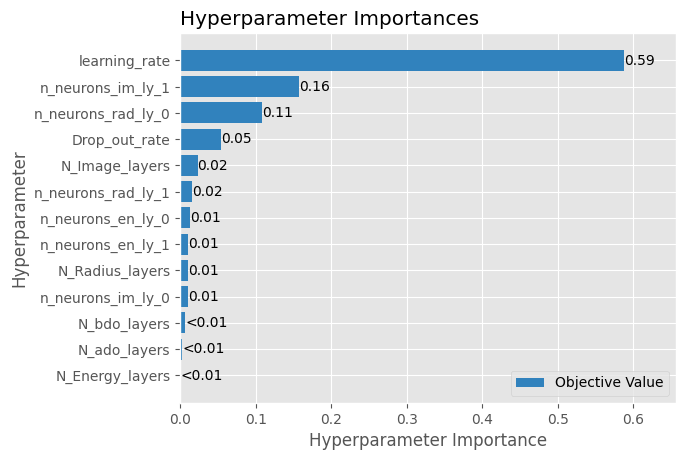

In [36]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.legend(loc = 'lower right')
plt.savefig('figs/Optimized Models/10x10/Hyperparameter Importance.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [37]:
best_model = create_OP_Model(best_trial)
history = best_model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train},
                    y = {'nu_predict':label_train}, 
                    epochs = 150, 
                    batch_size = 100,
                    validation_split = 0.3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-2)],
                    shuffle = True)

Epoch 1/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7571 - accuracy: 0.7175 - loss: 0.5822 - val_AUC: 0.5180 - val_accuracy: 0.5184 - val_loss: 0.8824
Epoch 2/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9228 - accuracy: 0.8443 - loss: 0.3498 - val_AUC: 0.9031 - val_accuracy: 0.7908 - val_loss: 0.3860
Epoch 3/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9739 - accuracy: 0.9107 - loss: 0.2063 - val_AUC: 0.8869 - val_accuracy: 0.7720 - val_loss: 0.4423
Epoch 4/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9827 - accuracy: 0.9289 - loss: 0.1676 - val_AUC: 0.9388 - val_accuracy: 0.8278 - val_loss: 0.3575
Epoch 5/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9842 - accuracy: 0.9359 - loss: 0.1590 - val_AUC: 0.9721 - val_accuracy: 0.8924 - val_loss: 0.2136
Epoch 6/150
730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9904 - accuracy: 0.9472 - loss: 0.1245 - val_AUC: 0.9631 - val_accuracy: 0.8700 - val_loss: 0.2705
Epoch 7/150
730/730 ━━━━━━━━━━━━━━

## 3.2 - Train and Validation Progress

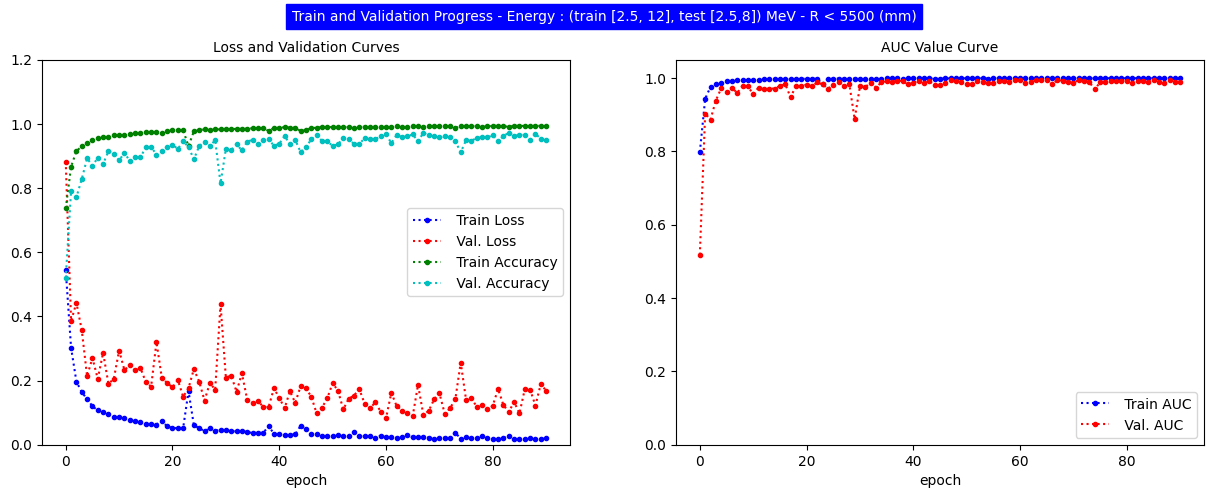

In [57]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[0].set_ylim(0, 1.2)
axes[1].set_ylim(0, 1.05)

fig.suptitle('Train and Validation Progress - Energy : (train [2.5, 12], test [2.5,8]) MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')
plt.show()

# *Save/Load Model

In [39]:
#Save model after training
#best_model.save('models/10x10/optimized models/MLM1_5500_plane_en_std_norm_vol_(2.5_12)_(-5_7)_aucOP.h5')

#Load Model
#best_model = tf.keras.models.load_model('models/10x10/optimized models/std_transf_models/Plane Solar Energy/MLM1_plain_en_train_5500_train_(2.5_12)_test(2.5_8)_(-5_7)_aucOP.h5')
#best_model.summary()

# 4 - Observation and Analysis of Predictions

### 4.1.1 - NN Prediction

In [40]:
X_sig_pred = best_model.predict([pixel_sig_test_transf, energy_sig_test_transf, radi_sig_test_transf])
X_bkg_pred = best_model.predict([pixel_bkg_test_transf, energy_bkg_test_transf, radi_bkg_test_transf])

980/980 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step


### 4.1.2 - Analysis of Predictions

In [41]:
X_sig_pred

array([[9.9999696e-01, 3.2755152e-06],
       [9.9982309e-01, 1.8477261e-04],
       [8.9494956e-01, 1.0419231e-01],
       ...,
       [9.9999982e-01, 1.6814802e-07],
       [9.9996984e-01, 3.1951142e-05],
       [9.9998802e-01, 1.2800175e-05]], dtype=float32)

In [42]:
X_bkg_pred

array([[6.9755930e-01, 3.0091897e-01],
       [5.4376535e-02, 9.4516975e-01],
       [1.9274162e-07, 9.9999982e-01],
       ...,
       [5.0248847e-08, 9.9999994e-01],
       [9.5211685e-04, 9.9907297e-01],
       [2.2064826e-10, 1.0000000e+00]], dtype=float32)

In [43]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 31338 of signal and 34720 of background as testing data


### 4.1.3 - Representation of Predictions

#### Distribution of Probabilities

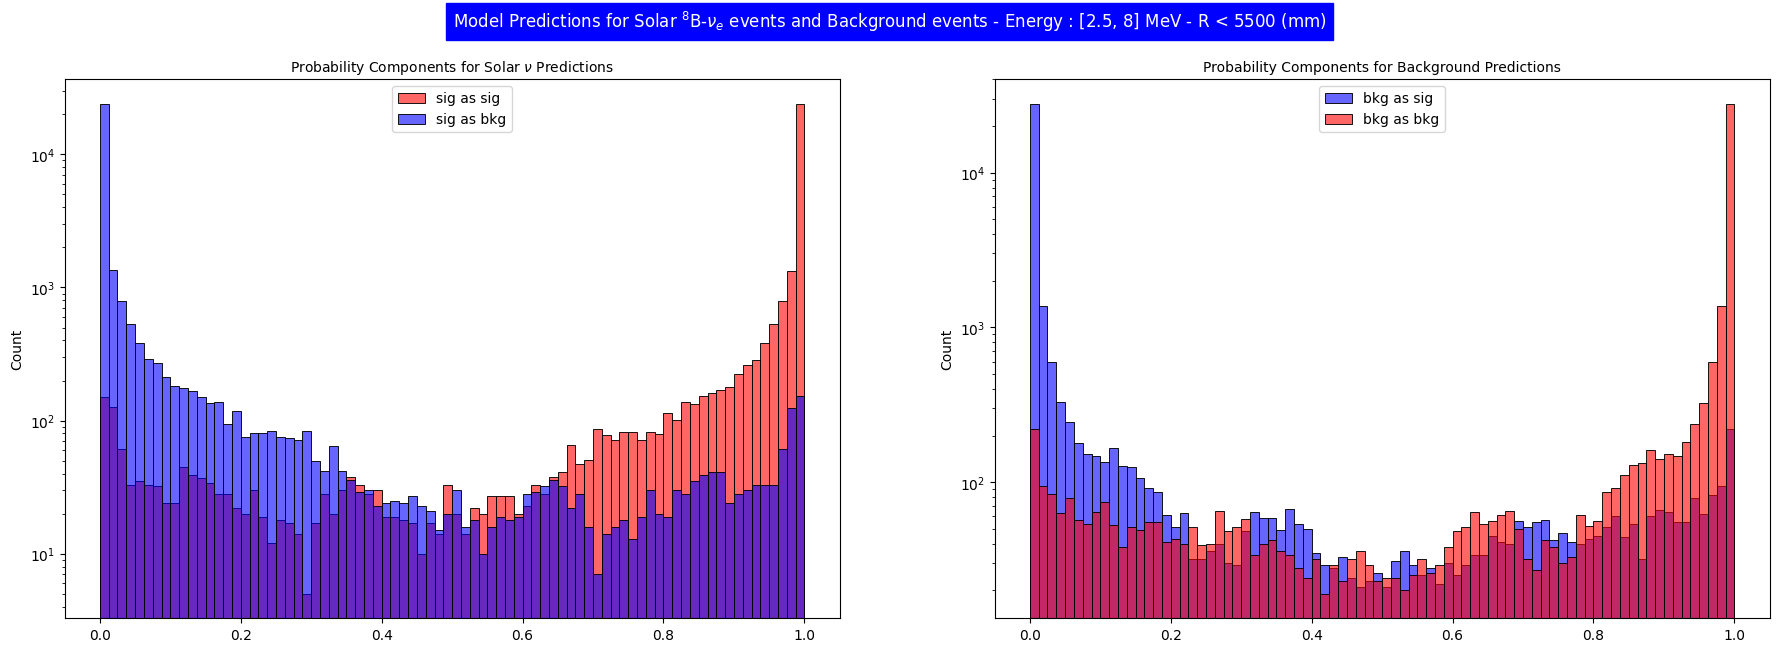

In [58]:
sn.reset_orig
bins = 80
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'sig as sig', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'sig as bkg', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'bkg as sig',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'bkg as bkg', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle('Model Predictions for Solar $^8$B-$ν_e$ events and Background events - Energy : [2.5, 8] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/Optimized Models/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')
plt.show()

- Deviation from Predictions

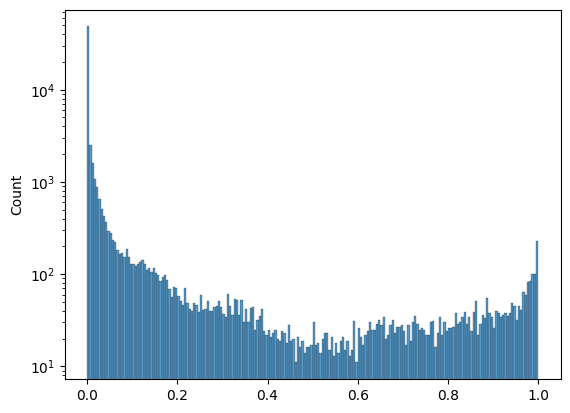

In [45]:
#Prediction of true as true
X_pred_nu_as_nu = X_sig_pred[:,0]
X_pred_tl_as_tl = X_bkg_pred[:,1]
X_pred_as_true = np.concatenate((X_pred_nu_as_nu, X_pred_tl_as_tl))

#Expected:
X_exp_nu = df_label_sig_test.values[:,0]
X_exp_tl = df_label_bkg_test.values[:,1]
X_exp = np.concatenate((X_exp_nu, X_exp_tl))

deviation = X_exp - X_pred_as_true
sn.histplot(deviation, bins = 200)
plt.yscale('log')
plt.show()

### 4.1.4 - ROC Curve

In [46]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))        #Predicted
X_exp = np.concatenate((df_label_sig_test, df_label_bkg_test)) #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

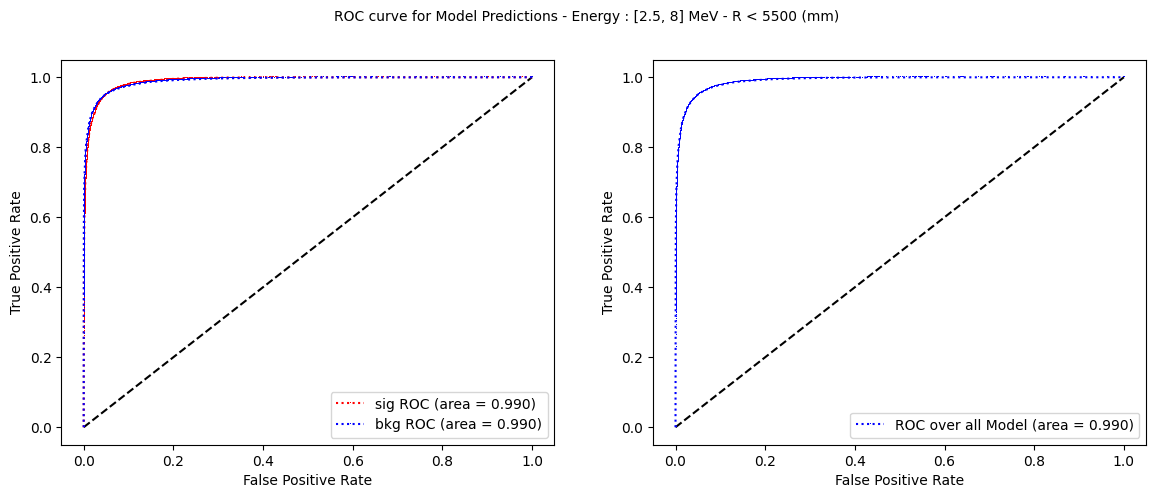

In [59]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.3f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.3f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.3f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle('ROC curve for Model Predictions - Energy : [2.5, 8] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 4.1.5 - Reconstrucción de espector de solar $ν_e$ y de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler) y Normalización en Volumen

In [49]:
energy_sig_rc = scaler_en_sig.inverse_transform([energy_sig_test_transf])[0]
energy_bkg_rc = scaler_en_bkg.inverse_transform([energy_bkg_test_transf])[0]

radi_sig_rc = scaler_rad_sig.inverse_transform([radi_sig_test_transf])[0]
radi_bkg_rc = scaler_rad_bkg.inverse_transform([radi_bkg_test_transf])[0]

# Volume Normalization: a formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
#radi_sig_rc = np.cbrt(radi_sig_test_transf*vol).values.T[0]
#radi_bkg_rc = np.cbrt(radi_bkg_test_transf*vol).values.T[0]

# Volume Normalization + Std Scaler: a formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
radi_sig_rc = np.cbrt(radi_sig_rc*vol)
radi_bkg_rc = np.cbrt(radi_bkg_rc*vol)

In [50]:
radi_sig_rc

array([3923.59545898, 5207.81005859, 3564.83740234, ..., 4665.62353516,
       3314.48657227, 5264.1171875 ])

In [51]:
max(energy_sig_rc)

7.99827241897583

In [52]:
max(radi_sig_rc)

5499.9716796875

### 4.1.6 - Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

### 4.1.7 - Graficos de Energia Reconstruida y de Eficiencia Normalizada para varios Threshold de Predicción del Modelo

##### Extraer Información para los Gráficos

In [60]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 20             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_nu = X_sig_pred[:,0]
prob_tl = X_bkg_pred[:,1]

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_spectrum = []
nu_energy_out_spectrum = []

tl_energy_in_spectrum = []
tl_energy_out_spectrum = []

#mean normalized eficiency values for signal and bkg
norm_eff_sig = []
norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_spectrum_thr = []
    nu_energy_out_spectrum_thr = []
    
    tl_energy_in_spectrum_thr = []
    tl_energy_out_spectrum_thr = []

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_thr = np.array([])
    norm_eff_bkg_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr
    for i in np.where(X_sig_pred[:,0] >= thr_i)[0]:
        nu_energy_in_spectrum_thr.append(energy_sig_rc[i])
        
    for j in np.where(X_sig_pred[:,0] < thr_i)[0]:
        nu_energy_out_spectrum_thr.append(energy_sig_rc[j])
    
    for m in np.where(X_bkg_pred[:,1] >= thr_i)[0]:
        tl_energy_in_spectrum_thr.append(energy_bkg_rc[m])
    
    for k in np.where(X_bkg_pred[:,1] < thr_i)[0]:
        tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_spectrum.append(np.array(nu_energy_in_spectrum_thr))
    nu_energy_out_spectrum.append(np.array(nu_energy_out_spectrum_thr))
    tl_energy_in_spectrum.append(np.array(tl_energy_in_spectrum_thr))
    tl_energy_out_spectrum.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_nu_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_nu)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_nu_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_nu_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_thr = np.append(norm_eff_sig_thr, norm_eff_interval)

    norm_eff_sig.append(norm_eff_sig_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_tl_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_tl)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_tl_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_tl_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_thr = np.append(norm_eff_bkg_thr, norm_eff_interval)
    
    norm_eff_bkg.append(norm_eff_bkg_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig = np.array(norm_eff_sig)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg = np.array(norm_eff_bkg)

#### Construir los Gráficos

- Energia

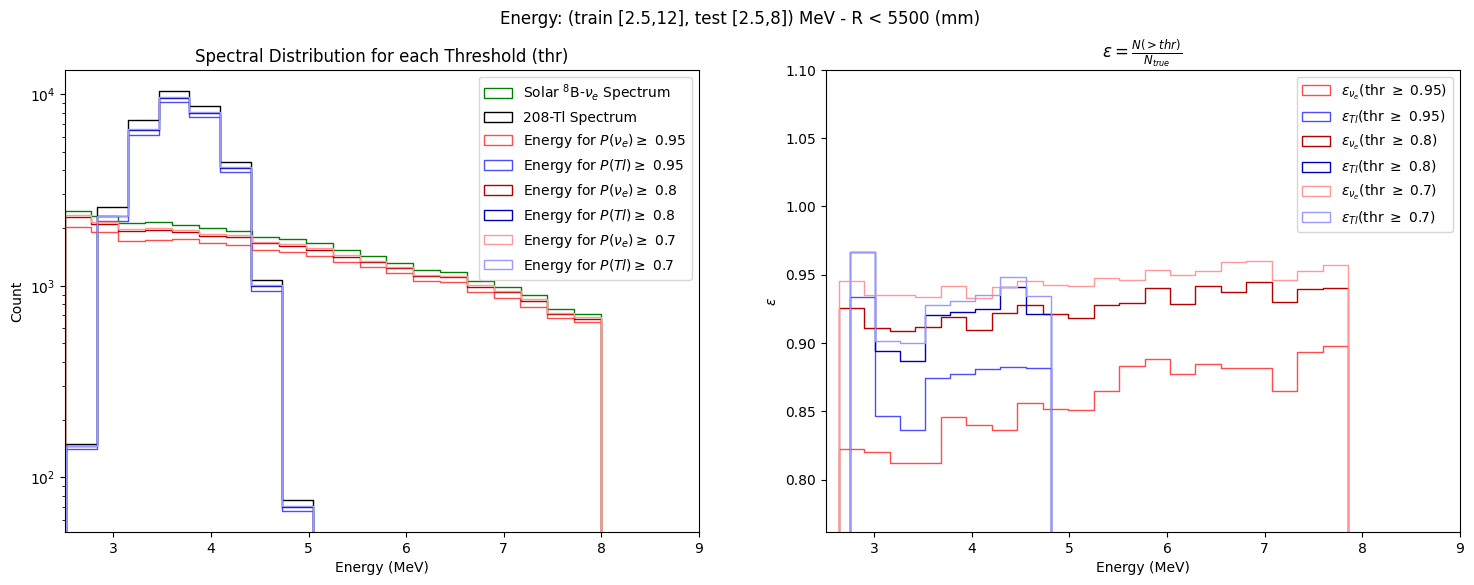

In [63]:
bkg_on = True
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 
sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'Solar $^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

if bkg_on:
    sn.histplot(energy_bkg_rc, ax = axes[0], bins = bins_tl, color = 'black' , label = r'208-Tl Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_spectrum[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'Energy for $P(ν_e) \geq$ ' + str(thr_i), 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{ν_e}$(thr $\geq$ '+str(thr_i)+')')

    if bkg_on:
        #bkg spectra
        sn.histplot(tl_energy_in_spectrum[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'Energy for $P(Tl) \geq$ ' + str(thr_i), 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        sn.histplot(x = mean_energy_bkg[i_dx], ax = axes[1], bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{Tl}$(thr $\geq$ '+str(thr_i)+')')
        

axes[0].set_title(r'Spectral Distribution for each Threshold (thr)', fontsize = 12)
axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Energy (MeV)')
axes[1].set_ylabel(r'$\epsilon$')

#Agregar marcadores al eje x
#x_en_ticks = np.arange(2.5, 12, 1)   #(x_min, x_max, step)
#axes[0].x_en_ticks(x_ticks)
#axes[1].x_en_ticks(x_ticks)

axes[0].set_xlim(2.5,9)
axes[1].set_xlim(2.5,9)
axes[1].set_ylim(np.min(norm_eff_sig) - 0.05, 1.10)

axes[0].set_yscale('log')
plt.suptitle('Energy: (train [2.5,12], test [2.5,8]) MeV - R < 5500 (mm)')

if bkg_on:
    plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff_sig_bkg.png', format = 'png', bbox_inches = 'tight')
else:
    plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()

- Radius

In [64]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_rad = 20            #-> BINS = 20
thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_nu = X_sig_pred[:,0]
prob_tl = X_bkg_pred[:,1]

rad_sig_test_count, rad_sig_test_edge = np.histogram(radi_sig_rc, bins = bins_rad)
rad_bkg_test_count, rad_bkg_test_edge = np.histogram(radi_bkg_rc, bins = bins_rad)

N_edges= len(rad_sig_test_edge)

#mean normalized eficiency values for signal and bkg
norm_eff_sig = []
norm_eff_bkg = []  

#mean radial values within each bin for signal and bkg data
mean_rad_sig = []
mean_rad_bkg = []

for thr_i in thr: 

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_thr = np.array([])
    norm_eff_bkg_thr = np.array([])
    
    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract norm_eff and mean radius within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges-1):
        #extract edges value of energy at each bin
        radi_edge_i = rad_sig_test_edge[i]
        radi_edge_f = rad_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), radi_sig_rc)
        prob_nu_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), prob_nu)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_sig_thr = np.append(mean_rad_sig_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_nu_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_nu_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_thr = np.append(norm_eff_sig_thr, norm_eff_interval)

    norm_eff_sig.append(norm_eff_sig_thr)
    mean_rad_sig.append(mean_rad_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges-1):
        #extract edges value of radius at each bin
        radi_edge_i = rad_bkg_test_edge[i]
        radi_edge_f = rad_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), radi_bkg_rc)
        prob_tl_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), prob_tl)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_bkg_thr = np.append(mean_rad_bkg_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_tl_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_tl_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract value of normalized efficiency for each bin
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_thr = np.append(norm_eff_bkg_thr, norm_eff_interval)
    
    norm_eff_bkg.append(norm_eff_bkg_thr)
    mean_rad_bkg.append(mean_rad_bkg_thr)
    

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_rad_sig = np.array(mean_rad_sig)
norm_eff_sig = np.array(norm_eff_sig)

mean_rad_bkg = np.array(mean_rad_bkg)
norm_eff_bkg = np.array(norm_eff_bkg)

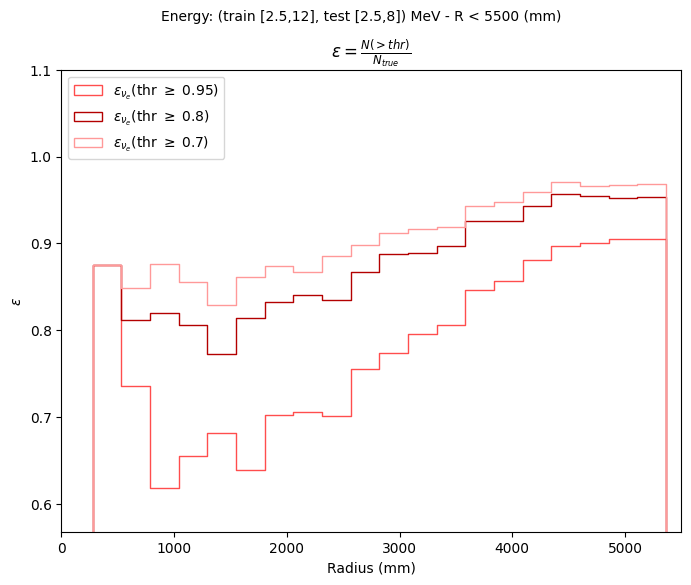

In [67]:
bkg_on = False

#main plot: Test Solar radius vs. Normalized efficiency
plt.figure(figsize =(8, 6)) 

for i_dx, thr_i in enumerate(thr):  
    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_rad_sig[i_dx], bins = len(mean_rad_sig[i_dx]), color = red_variants[i_dx], 
                weights = norm_eff_sig[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{ν_e}$(thr $\geq$ '+str(thr_i)+')')

    if bkg_on:
        #bkg efficiency
        sn.histplot(x = mean_rad_bkg[i_dx], bins=len(mean_rad_bkg[i_dx]), color = blue_variants[i_dx], kde=False,
                    weights = norm_eff_bkg[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{Tl}$(thr $\geq$ '+str(thr_i)+')')
        

plt.title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
plt.suptitle('Energy: (train [2.5,12], test [2.5,8]) MeV - R < 5500 (mm)', fontsize = 10)
plt.legend(loc = 'upper left')

plt.xlabel('Radius (mm)')
plt.ylabel(r'$\epsilon$')

plt.xlim(0, 5500.0)
plt.ylim(np.min(norm_eff_sig) - 0.05, 1.1)

if bkg_on:
    plt.savefig('figs/Optimized Models/10x10/Radial_sig_bkg_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
else:
    plt.savefig('figs/Optimized Models/10x10/Radial_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 4.1.6 - Efficience curve of predictions

Representar curva de eficiencia de las prediciones del modelo (sig=X_pred[:0], bkg=X_pred[:1]) en función de la energia y el radio del evento

In [53]:
#Efficiencia = Prob. de estar correcta la prediccion
X_sig_eff = X_sig_pred[:,0]
X_bkg_eff = X_bkg_pred[:,1]

x = np.concatenate((energy_sig_rc, energy_bkg_rc))
y = np.concatenate((radi_sig_rc, radi_bkg_rc))
z = np.concatenate((X_sig_eff, X_bkg_eff))

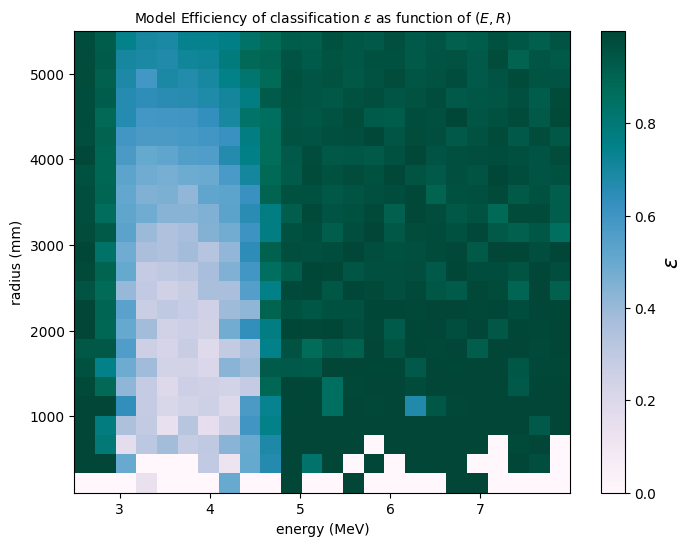

In [54]:
bins = 25

# Definir los límites y número de bins
x_edges = np.linspace(x.min(), x.max(), bins)
y_edges = np.linspace(y.min(), y.max(), bins)

# Inicializar una matriz para almacenar los valores de z
hist = np.zeros((len(x_edges)-1, len(y_edges)-1))

# Calcular los valores de z en cada bin
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.sum(mask) > 0:
            hist[i, j] = np.mean(z[mask])  # Otras estadísticas podrían ser np.sum, np.median, etc.

# Crear el plot
fig, ax = plt.subplots(figsize=(8,6))
c = ax.pcolormesh(x_edges, y_edges, hist.T, shading='auto', cmap = cm.PuBuGn)
cbar = fig.colorbar(c, ax=ax)

# Agregar un título a la barra de color
cbar.set_label('$ε$', fontsize = 15)

ax.set_xlabel('energy (MeV)')
ax.set_ylabel('radius (mm)')
ax.set_title('Model Efficiency of classification $ε$ as function of $(E,R)$', fontsize = 10)
#plt.xlim(0.5,16)
#plt.ylim(0,5500)
#plt.savefig('figs/Optimized Models/10x10/Eff_of_clasification(E,R).png', format = 'png', bbox_inches = 'tight')
plt.show()